In [1]:
import pandas as pd
from pathlib import Path
from time import sleep
import json

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import colormaps
import matplotlib.colors
import seaborn as sns
rd_ticks = [1,33,65, 100, 137, 174, 214, 256]

# https://www.statsmodels.org/dev/glm.html#families
import statsmodels.api as sm

from scipy import odr
from scipy.optimize import curve_fit
from scipy.stats import percentileofscore
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, \
                              make_interp_spline, CubicHermiteSpline, BSpline, splrep
from scipy.special import expit

def inv_sigmoid(x, x0, k, b):
    return expit(k*(-x+x0))+b

# Statsmodels warning for Gamma with InversePower link: 
import warnings
# domain_warning = sm.tools.sm_exceptions.DomainWarning

In [3]:
# draft+market table
data = pd.read_parquet(Path('data','draft_market_join_1pos.parquet'))
data.loc[:,'delta'] = data.next_Cap-data.Cap

market = {}
market['next'] = pd.read_csv(Path('tables','second-contract_market_fits.csv'),
                             index_col=0)
market['max'] = pd.read_csv(Path('tables','max-contract_market_fits.csv'),
                             index_col=0)

*cleaning* 
 - drop high wAVpG, low games played
   - lower than 20th percentile games, higher than 80th percentile wAVpG
     - could lower wAVpG threshold to 70, 75
   - see first cell for 5 players. iDL, WR, T, G, TE

In [4]:
drop_ind = []
for pos in  data.market_Pos.unique():
    sub = data[data.market_Pos==pos]
    sub = sub[(sub.Games <= sub.Games.quantile(0.2)) &
              (sub.wAVpG >= sub.wAVpG.quantile(0.8))
               ]
    if not sub.empty:
        drop_ind.extend(sub.index.values)
        #print(pos, sub.Player.values[0], '|',sub.Drafted.values[0], sub.Games.values[0], 'games')
data.loc[drop_ind,
    ['Rnd','Pick','Tm','Player','Pos','market_Pos','College','Drafted','Yrs_Starter','vet_contracts','Games','wAVpG','delta']
]       

Rnd  Pick   Tm          Player Pos market_Pos        College  Drafted  \
1318    2    35  SEA  Malik McDowell  DT        iDL   Michigan St.     2017   
2294    7   229  SEA       Bo Melton  WR         WR        Rutgers     2022   
604     7   242  SEA   Michael Bowie   T          T  NE State (OK)     2013   
1162    4   105  KAN  Parker Ehinger   G          G     Cincinnati     2016   
658     2    49  NYJ      Jace Amaro  TE         TE     Texas Tech     2014   

      Yrs_Starter  vet_contracts  Games     wAVpG     delta  
1318            1              1     15  0.400000 -0.401162  
2294            0              1      5  0.400000  0.070572  
604             0              1      9  0.444444 -0.026610  
1162            0              3     10  0.400000 -0.118821  
658             0              1     17  0.235294 -0.229396

In [5]:
# high wAVpG, low games played. see
drop_ind = [1318, 2294, 604, 1162, 658]
data.drop(index=drop_ind, inplace=True)

### Draft Performance Fit
 - GLM gamma distribution
   - C, WR, T, S, QB, LB, iDL, G, EDGE, CB
 - 3d polynomial
   - TE, RB

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


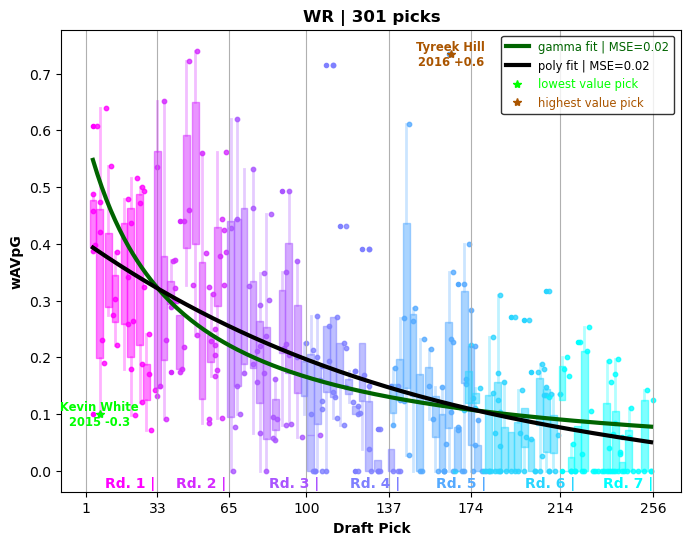

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


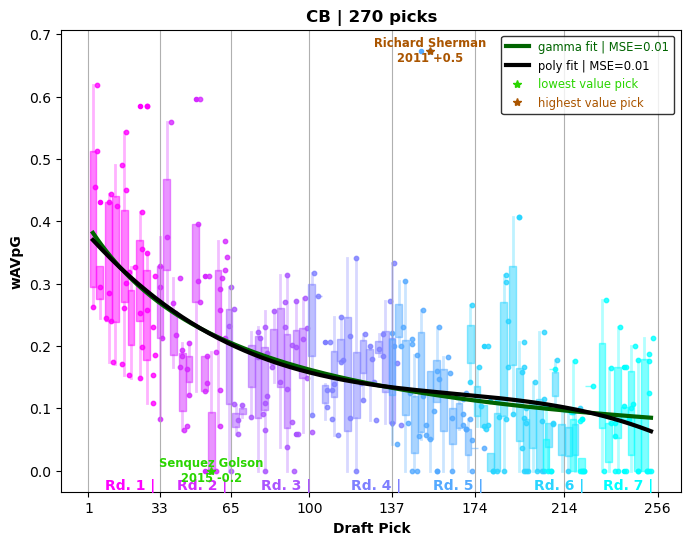

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


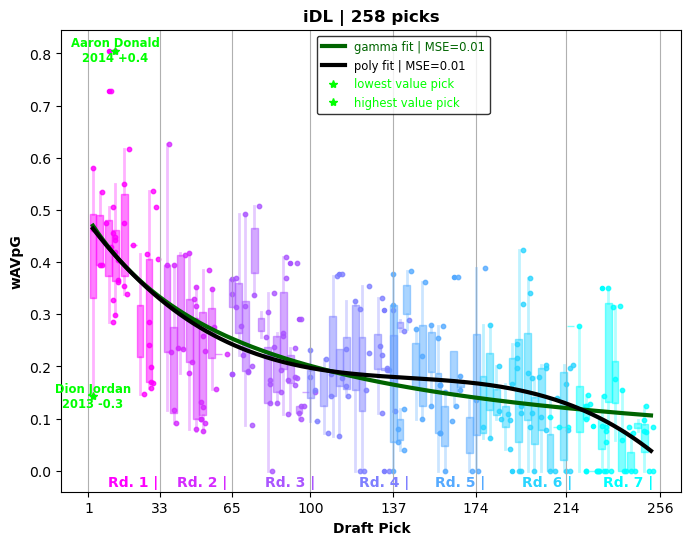

In [10]:
cmap = colormaps['cool_r']

for pos in ['WR', 'CB', 'iDL',]:
# for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    sub = data[data.market_Pos == pos]
    plt.figure(figsize=(8,6))
    n_colors = sub.Rnd.unique().shape[0]    
    colors = cmap(np.linspace(0,1,n_colors))


    for i,draft_rd in enumerate(np.sort(sub.Rnd.unique())):
        sub2 = sub[sub.Rnd==draft_rd]
        rd_color = colors[i]
        s = plt.scatter(sub2.Pick, sub2.wAVpG, s=10, alpha=0.8, color=rd_color) #  alpha=0.4, linewidths=0, s=20

        m = np.linspace(sub2.Pick.min(),sub2.Pick.max(), 
                        int((sub2.Pick.max()-sub2.Pick.min())/3)).astype(int)
        ms = {m[i]: sub2[sub2.Pick.between(m[i], m[i+1])].wAVpG.values for i in range(m.shape[0]-1)}

        pb1 = plt.boxplot(x=ms.values(), positions=m[:-1], widths=m[1]-m[0], 
                          patch_artist=True, medianprops={'linewidth':0},
                          manage_ticks=False, showcaps=False) # , zorder=0
        plt.setp(pb1['whiskers'], linewidth=2, alpha=0.3, color=rd_color,) # 
        plt.setp(pb1['fliers'],  markersize=3, markeredgecolor=rd_color, markerfacecolor=rd_color,) # markeredgecolor='k',markerfacecolor='k',
        plt.setp(pb1['boxes'], alpha=0.5, color=rd_color) # 
        plt.text(sub2.Pick.max(), -0.03, f'Rd. {draft_rd} |',
                 color=rd_color, ha='right', fontweight='bold')
# CURVE FITS
    mx = sm.add_constant(sub.Pick)
    sq_resp = np.sum(sub.wAVpG**2)
    x = np.arange(sub.Pick.min(),sub.Pick.max())
    
    # Gamma
    gamma = sm.GLM(sub.wAVpG, mx, family=sm.families.Gamma()).fit()
    plt.plot(x, gamma.predict(sm.add_constant(x)), 
             '-', linewidth=3, color='darkgreen',
             label=f'gamma fit | MSE={np.mean(gamma.resid_response**2):.2f}')  #  {round(100*np.sum(gamma.resid_response**2)/sq_resp,1)}
    # 3D Poly
    poly_fit = np.polyfit(sub.Pick, sub.wAVpG, 3,  full=True) 
    poly_pred = np.poly1d(poly_fit[0])(sub.Pick)
    poly_resid = pd.Series(sub.wAVpG-poly_pred, index=sub.index)
    plt.plot(x, np.poly1d(poly_fit[0])(x), 'k-', linewidth=3,
             label=f'poly fit | MSE={np.mean(poly_resid**2):.2f}')
    
    
    # player labels | poly_pred OR gamma.resid_response  SERIES
    low = poly_resid.sort_values().index[0]
    high = poly_resid.sort_values(ascending=False).index[0]
    for ind in [low,high]:
        player = sub.loc[ind]
        inv_color = [1-val for val in colors[player.Rnd-1][:-1]]
        plt.plot(player.Pick, player.wAVpG, '*', color=inv_color, 
                 label=f'{"highest" if poly_resid[ind]>0 else "lowest"} value pick')
        
        plt.text(player.Pick, player.wAVpG,
f"{player.Player}\n{player.Drafted} {'+' if poly_resid[ind]>0 else ''}{poly_resid[ind]:.1f}",
                 color=inv_color, fontsize='small', ha='center', 
                 va='center', fontweight='bold')
    
    plt.legend(labelcolor='linecolor', frameon=True, edgecolor='k', 
               bbox_to_anchor=(0.7,1), fontsize='small')
    plt.title(f'{sub.market_Pos.unique()[0]} | {sub.shape[0]} picks', fontweight='bold')
    plt.xlabel('Draft Pick', fontweight='bold')
    plt.ylabel('wAVpG', fontweight='bold')
    plt.xticks(rd_ticks)
    plt.grid(axis='x')

    # plt.savefig(Path('market_graphs', 'draft fits 2', f'{pos}_poly.png'), dpi=200, bbox_inches='tight')
    plt.show()

##### Rd 1,2

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


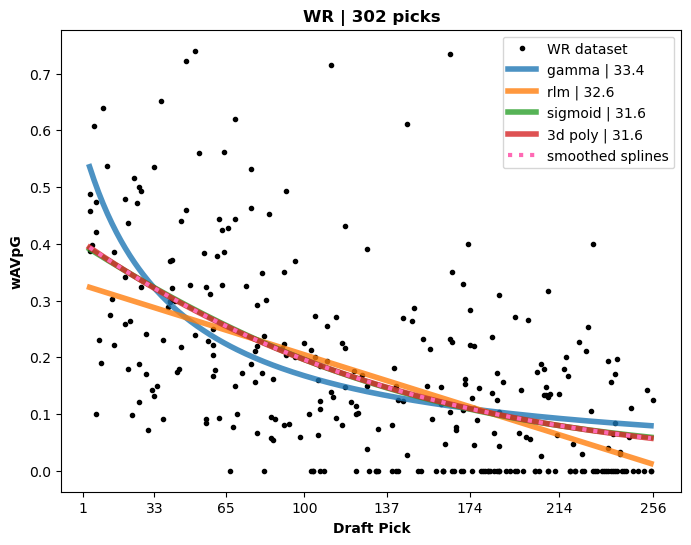

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


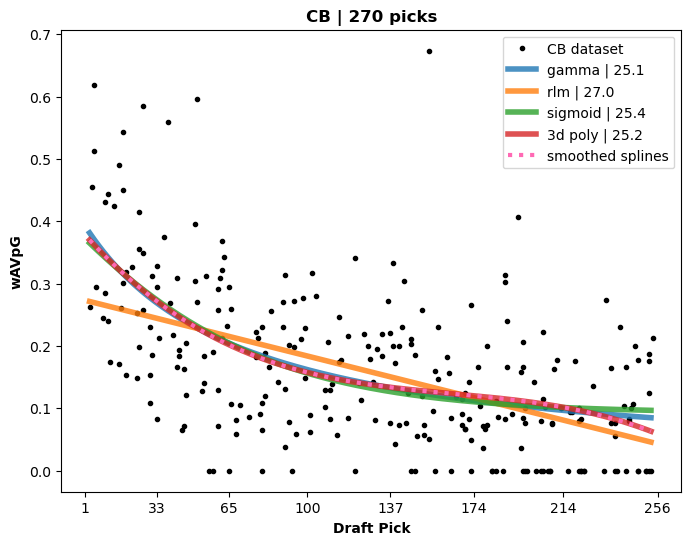

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


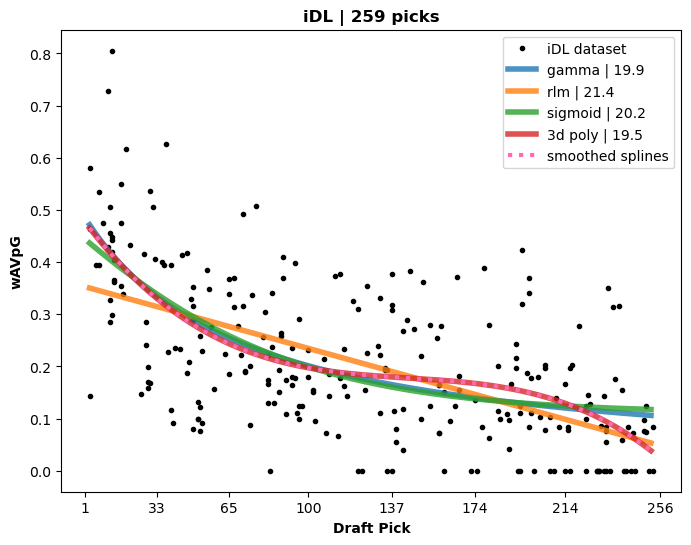

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\Nish\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


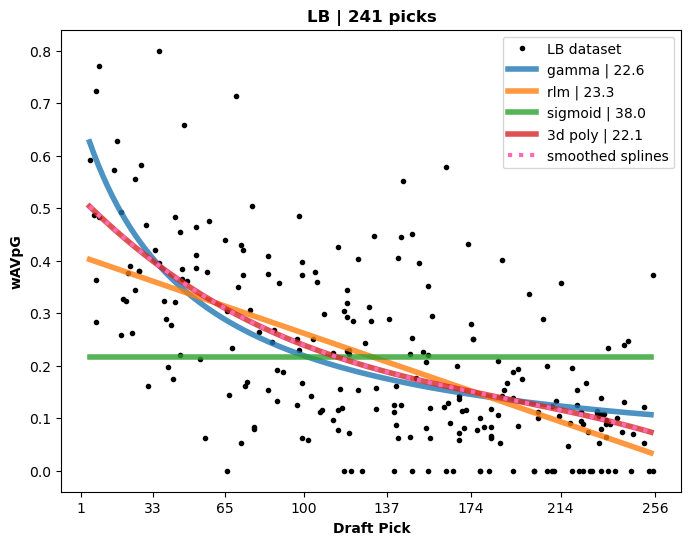

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


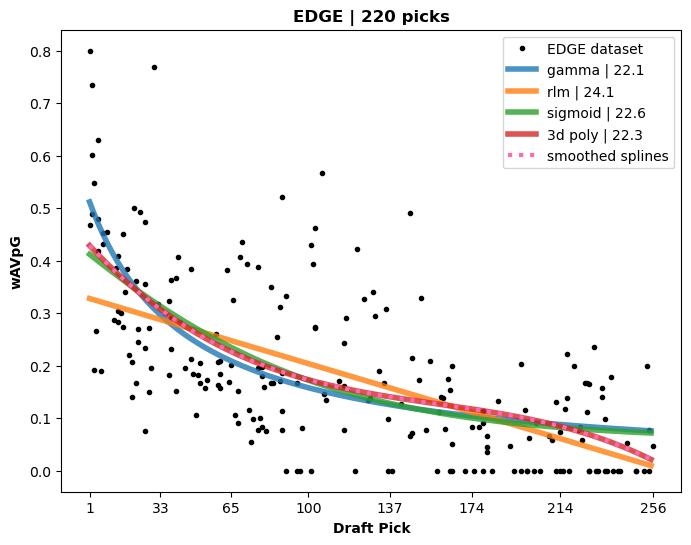

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\Nish\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


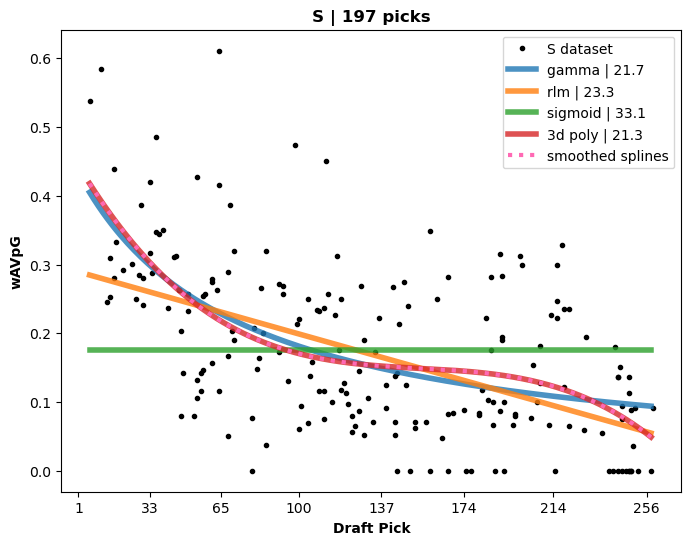

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


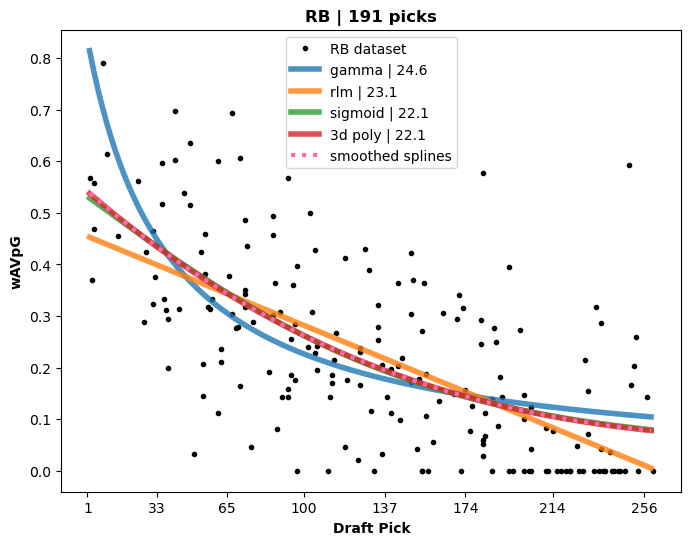

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


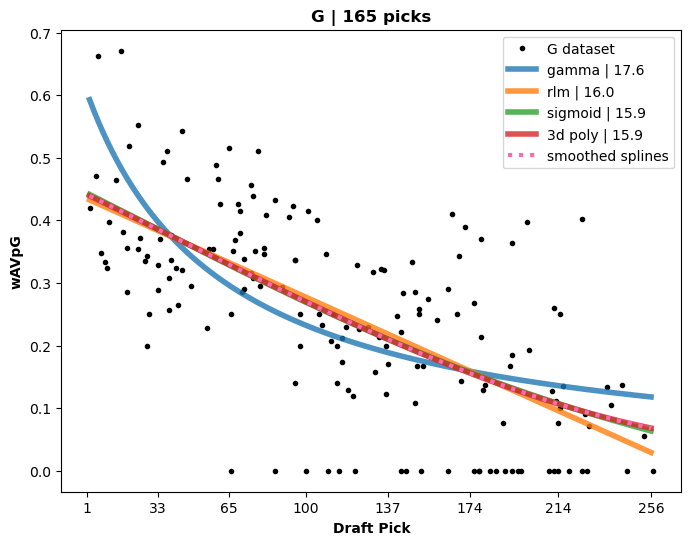

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


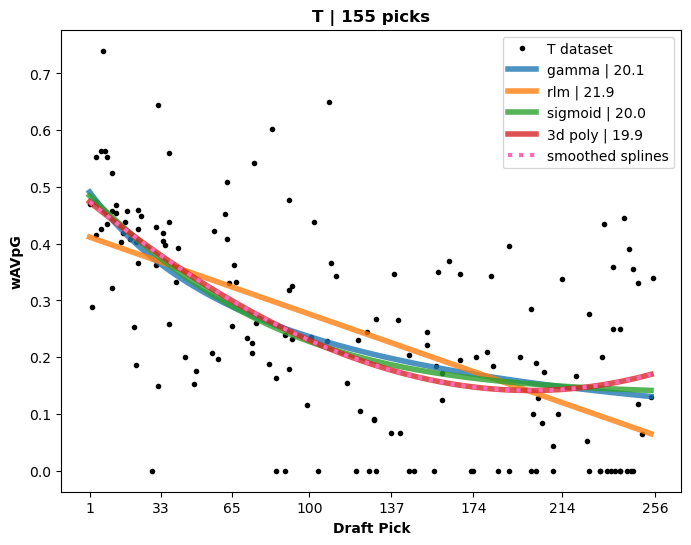

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\Nish\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


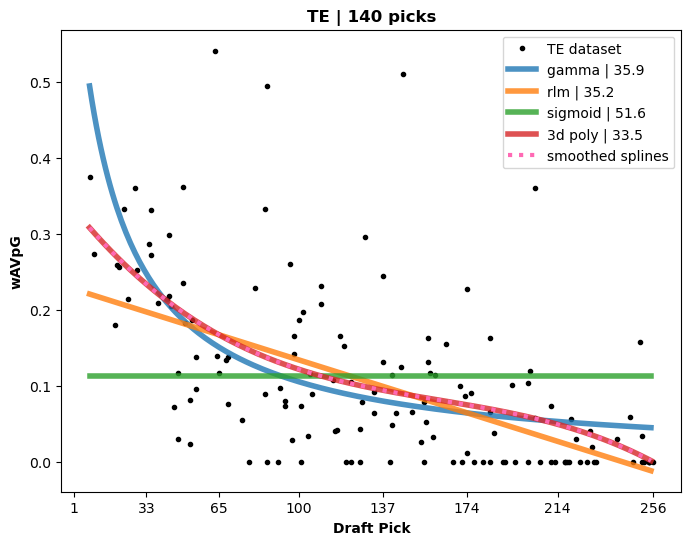

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


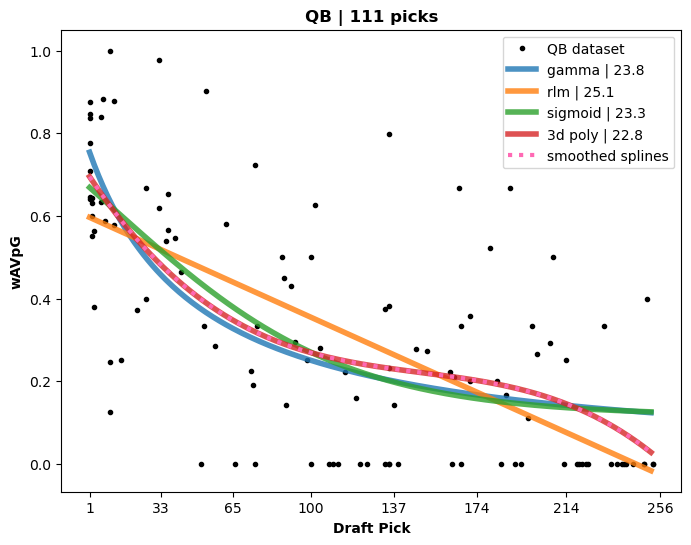

C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\Nish\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


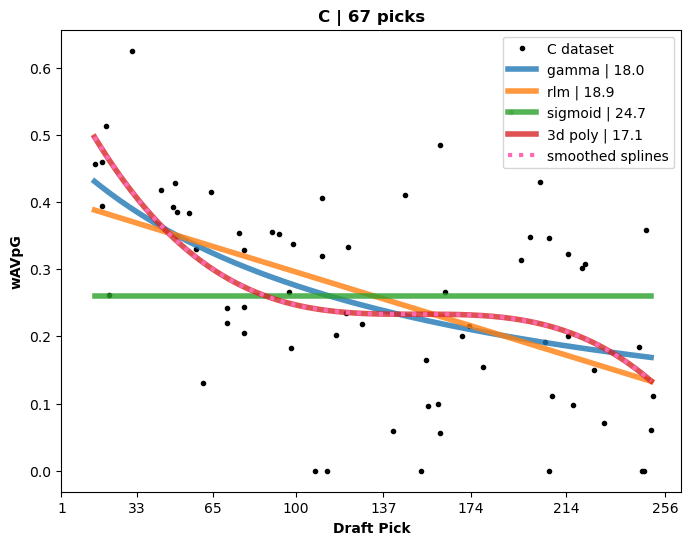

In [142]:
for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    sub = data[data.market_Pos == pos]
    plt.figure(figsize=(8,6))
    plt.plot(sub.Pick, sub.wAVpG, 'k.', label=f'{sub.market_Pos.unique()[0]} dataset')

        # CURVE FITS
    mx = sm.add_constant(sub.Pick)
    sq_resp = np.sum(sub.wAVpG**2)
    x = np.arange(sub.Pick.min(),sub.Pick.max())

    # linear models
    gamma = sm.GLM(sub.wAVpG, mx, family=sm.families.Gamma()).fit()
    plt.plot(x, gamma.predict(sm.add_constant(x)), 
             '-', linewidth=4, alpha=0.8,
             label=f'gamma | {round(100*np.sum(gamma.resid_response**2)/sq_resp,1)}')

    rlm = sm.RLM(sub.wAVpG, mx).fit()
    plt.plot(x, rlm.predict(sm.add_constant(x)), '-', linewidth=4, alpha=0.8,
             label=f'rlm | {round(100*np.sum(rlm.resid**2)/sq_resp,1)}')

    # sigmoid
    popt, _ = curve_fit(inv_sigmoid, sub.Pick, sub.wAVpG)
    sig_resid = np.sum((inv_sigmoid(sub.Pick, *popt)-sub.wAVpG)**2)
    plt.plot(x, inv_sigmoid(x, *popt), 
             '-', linewidth=4, alpha=0.8,
             label=f'sigmoid | {round(100*sig_resid/sq_resp,1)}')

    # poly
    poly_fit = np.polyfit(sub.Pick, sub.wAVpG, 3,  full=True) 
    plt.plot(x, np.poly1d(poly_fit[0])(x), 
             '-', linewidth=4, alpha=0.8,
             label=f'3d poly | {round(100*poly_fit[1][0]/sq_resp,1)}')

    # smoothed spline
    # tck_s = splrep(sub.sort_values('Pick').Pick, sub.sort_values('Pick').wAVpG, s=sub.shape[0]/5,)
    # plt.plot(x, BSpline(*tck_s)(x), ':', linewidth=3, color='hotpink',
    #          label=f"smoothed splines") 
    #  {round(100*np.sum((BSpline(*tck_s)(sub.sort_values('Pick').Pick) - sub.sort_values('Pick').wAVpG)**2)/sq_resp,1)}


    plt.legend()
    plt.title(f'{sub.market_Pos.unique()[0]} | {sub.shape[0]} picks', fontweight='bold')
    plt.xlabel('Draft Pick', fontweight='bold')
    plt.ylabel('wAVpG', fontweight='bold')
    plt.xticks(rd_ticks)
    plt.savefig(Path('market_graphs', 'draft fits 2', f'{pos}.png'), dpi=200, bbox_inches='tight')
    plt.show()

### Random Graphs

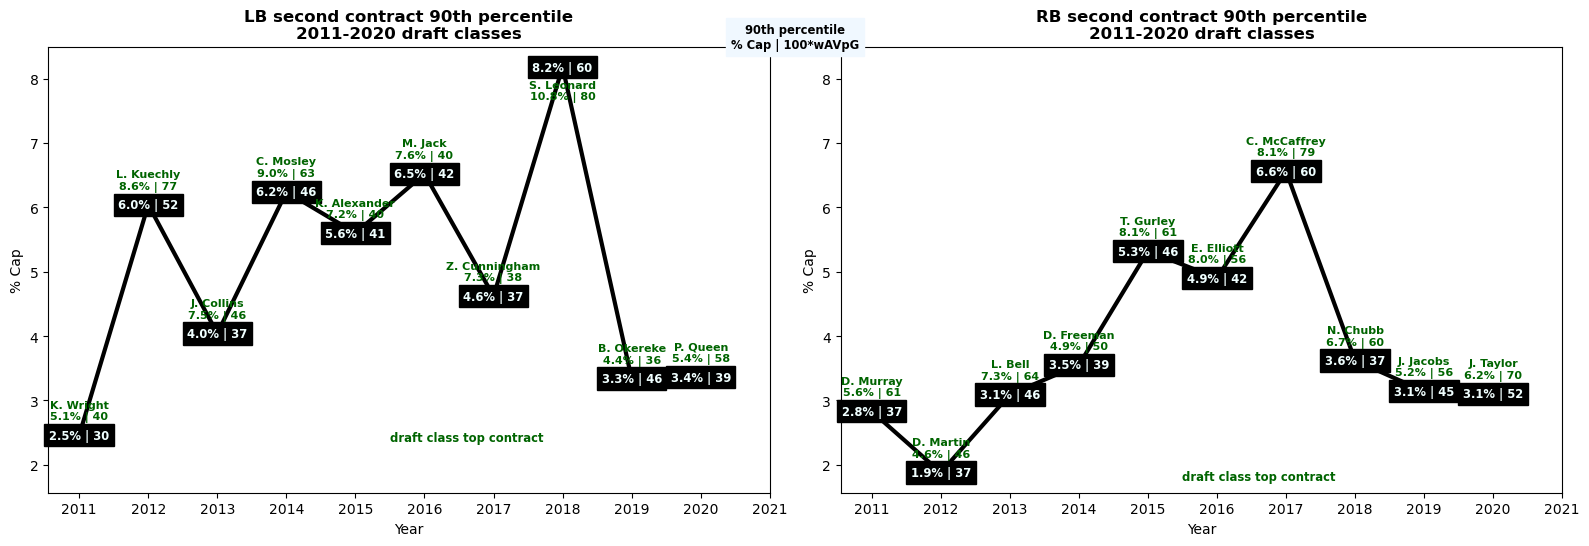

In [11]:

# ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']
comp_list = ['LB','RB']
py = 'next_Cap'
q = 0.9

plt.figure(figsize=(8+len(comp_list)*4,6), tight_layout=True)
for i,pos in enumerate(comp_list): 
    if i == 0 or 'QB' in comp_list:
        plt.subplot(1, len(comp_list), i+1)
    else:
        plt.subplot(1, len(comp_list), i+1, sharey=line[0]._axes)
    sub = data[(data.market_Pos == pos) ] # & (data.Drafted<2024)
    p = sub.groupby('Drafted')[[py,'wAVpG']].quantile(q)
    p = p[p[py]>=1]
    line = plt.plot(p.index, p[py], 'k.-', label=pos, 
             linewidth=3, markersize=15,)
    yt = plt.yticks()[0]
    yt = (yt[1]-yt[0])/5
    yb = plt.ylim()
    
    # label points
    for year in p.index:
        plt.text(year, p.loc[year,py] ,
                 f"{p.loc[year,py]:.1f}% | {100*p.loc[year,'wAVpG']:.0f}",
                 color='azure', backgroundcolor=line[0].get_c(), fontweight='bold',
                 ha='center', va='center',  fontsize='small')
       
        top = sub[sub.Drafted==year].sort_values(py,ascending=False)
        c_name = f"{top.Player.values[0].split(' ')[0][0]}. {top.Player.values[0].split(' ')[-1]}"
        c_stats = f"{top[py].values[0]}% | {100*top.wAVpG.values[0]:.0f}"
        c_top = False if yb[1]-p.loc[year,py] < 1 else True        
        plt.text(year, p.loc[year,py]+yt if c_top else p.loc[year,py]-yt, 
                 f"{c_name}\n{c_stats}", ha='center', zorder=3,
                 fontsize=8, color='darkgreen', fontweight='bold',
                 va='bottom' if c_top else 'top')
    

    
    t = plt.yticks()
    plt.xticks(data[data.Drafted<2022].Drafted.unique())
    plt.text(p.index.values.mean(), yb[0]+yt, f"draft class top contract", 
         color='darkgreen', fontweight='bold', fontsize='small',)
    plt.xlabel('Year')
    plt.ylabel('% Cap')
    plt.title(
f"{pos} {'max' if py=='max_Cap' else 'second'} contract {q*100:.0f}th percentile\n{p.index.min()}-{p.index.max()} draft classes", 
              fontweight='bold')
    plt.suptitle(f'{q*100:.0f}th percentile\n% Cap | 100*wAVpG', backgroundcolor='aliceblue', 
                 y=0.88, fontsize='small', fontweight='bold')

# plt.savefig(f'market_graphs/top_market_compare/top_market_compare_{py}_{"-".join(comp_list)}.png', dpi=200)
plt.show()

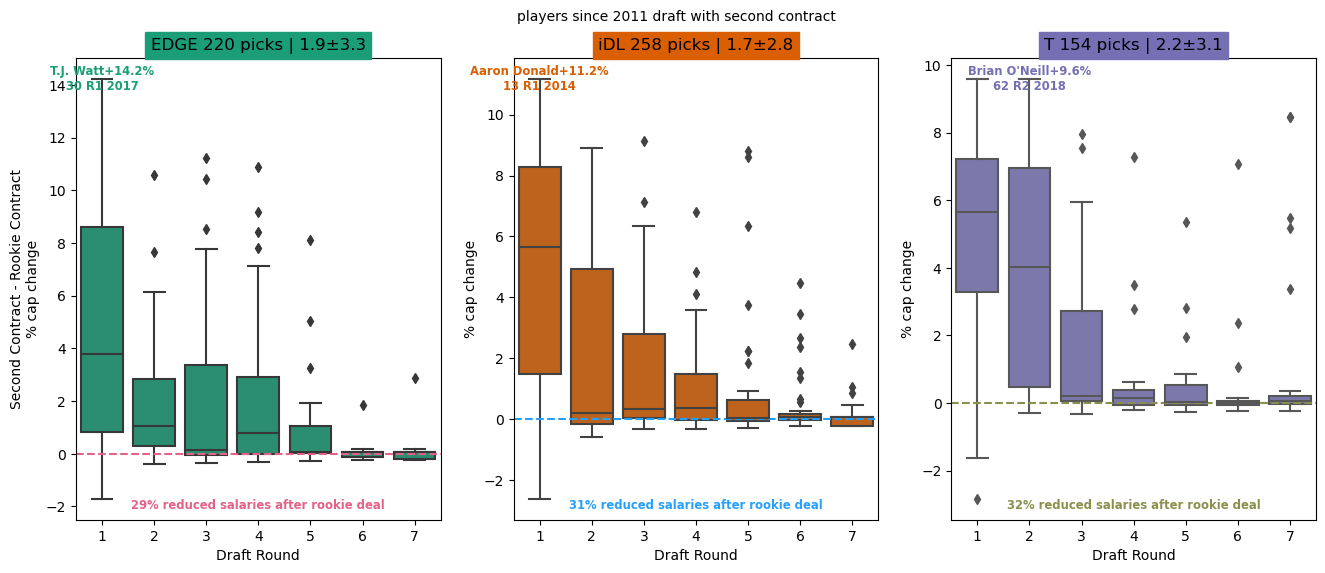

In [12]:


colors = colormaps['Dark2'].colors
pos_list = ['EDGE','iDL','T']

plt.figure(figsize=(4+4*len(pos_list),6))

for i,pos in enumerate(pos_list):
    plt.subplot(1,len(pos_list),i+1)
    sub = data[data.market_Pos==pos]
    sns.boxplot(sub, y='delta', x='Rnd', color=colors[i])
    xb = plt.xlim()
    plt.plot(xb, (0,0), '--', color=[1-val for val in colors[i]])
    
    plt.text(np.mean(xb), sub.delta.min(), 
             f'{100*sub[sub.delta<0].shape[0]/sub.shape[0]:.0f}% reduced salaries after rookie deal',
             fontsize='small', fontweight='bold', ha='center', va='top',
             color=[1-val for val in colors[i]])
    
    top = sub[sub.delta==sub.delta.max()]
    top_player = top.Player.values[0], top.Rnd.values[0], top.Drafted.values[0], top.Pick.values[0]
    plt.text(top.Rnd.values[0]-1, top.delta.values[0],
f"{top_player[0]}+{top.delta.values[0]:.1f}%\n{top_player[3]} R{top_player[1]} {top_player[2]}", 
             va='center', fontsize='small', color=colors[i], ha='center', fontweight='bold')
             
    
    plt.title(f'{pos} {sub.shape[0]} picks | {sub.delta.mean():.1f}±{sub.delta.std():.1f}', backgroundcolor=colors[i])
    if i == 0:
        plt.ylabel('Second Contract - Rookie Contract\n% cap change')
        plt.xlabel('Draft Round')
    else:
        plt.ylabel('% cap change')
        plt.xlabel('Draft Round')
    plt.suptitle('players since 2011 draft with second contract', fontsize='medium', y=0.96)

# plt.savefig(f'market_graphs/delta_vs_draft-rnd_{"-".join(pos_list)}.png', dpi=200, bbox_inches='tight')
plt.show()

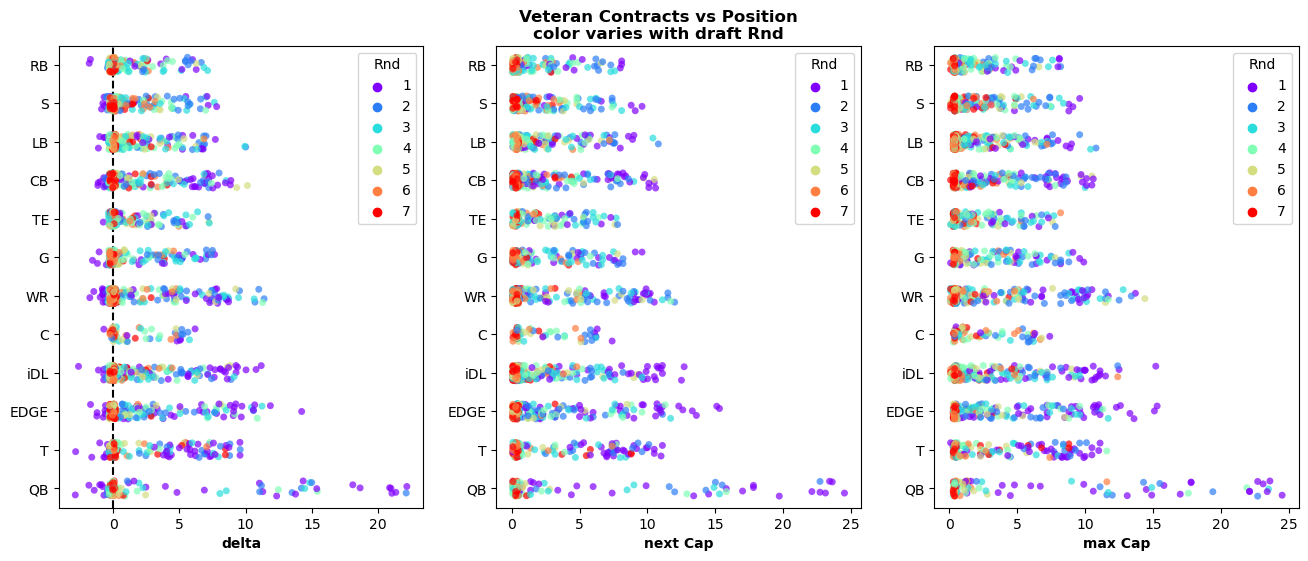

In [13]:
plt.figure(figsize=(16,6))

study = 'market_Pos'
fx_list = ['delta','next_Cap','max_Cap']
hueby = 'Rnd'
palette = 'rainbow' # nipy_spectral

cat_order = data[data[hueby]>0].groupby(study)[fx_list[1]].mean().sort_values().index

for i,fx in enumerate(fx_list):
    plt.subplot(1,len(fx_list),i+1)
    sns.stripplot(data, x=fx, y=study, hue=hueby, order=cat_order,
                  palette=palette, alpha=0.7, jitter=0.2, )
    if fx=='delta':
        yb = plt.ylim()
        plt.plot((0,0),yb,'k--')
        plt.ylim(yb)
    plt.ylabel('')
    plt.xlabel(fx.replace('_',' '),fontweight='bold')
plt.suptitle(f'Veteran Contracts vs Position\ncolor varies with{" draft " if hueby!="wAVpG" else " "}{hueby}', y=0.94, fontweight='bold')
# plt.savefig(f'market_graphs/pos_summary_colorby-{hueby}.png', dpi=200, bbox_inches='tight')
plt.show()    

### Final Graph Functions
 - `market_fit_params(market, pos, cap_type)`
   - return market fit parameters (series)
 - `draft_fit_params(data, pos)`
   - return fitted model for performance vs pick, and model type
 - `draft_surplus_pick(ax, data, pos, market, cap_type, labels=False)`
   - *graph*, surplus, market, rookie rates vs draft pick
 - `draft_surplus_performance(ax, data, pos, market, cap_type, labels=False)`
   - *graph*, surplus, market, rookie rates vs wAVpG (performance)
 - `market_fit(ax, data, pos, market, cap_type, labels=False)`
   - *graph*, illustrate market rate (% cap vs performance)
 - `draft_fit(ax, data, pos, labels=False):`
   - *graph*, illustrate draft performance fit (wAVpG vs draft pick)

##### Fit Params

In [14]:
def market_fit_params(market, pos, cap_type):
    fit_params = market[cap_type].loc[pos]
    px = 'wAVpG'
    py = f'{cap_type}_Cap'
    return market[cap_type].loc[pos]

In [15]:
def draft_fit_params(data, pos):
    sub = data[data.market_Pos == pos]
    if pos in ['TE','RB']:
        mod = np.polyfit(sub.Pick, sub.wAVpG, 3,  full=True)[0]
        mod_type = 'poly'
    else:
        mod = sm.GLM(sub.wAVpG, sm.add_constant(sub.Pick), 
                     family=sm.families.Gamma()).fit()  
        mod_type = 'GLM'
    return mod, mod_type

##### Surplus vs Pick

In [16]:
def draft_surplus_pick(ax, data, pos, market, cap_type, labels=False):
    sub = data[data.market_Pos == pos]
    
        # Draft Fit | Pick, % Cap, fit wAVpG
    mod, mod_type = draft_fit_params(data,pos)
    draft =  sub.groupby('Pick').Cap.mean()
    # predict wAVpG from pick
    if mod_type == 'GLM':
        draft_fx = mod.predict(sm.add_constant(draft.index))
    elif mod_type == 'poly':
        draft_fx = np.poly1d(mod)(draft.index)
    draft_curve = ax.plot(draft.index, draft.values, # % cap vs Pick
                          '-',  label='rookie cap')

        # Market Fit | wAVpG, fit % Cap
    market_fit = market_fit_params(market, pos, cap_type)
    # predict % Cap from wAVpG, indicate extrapolation (down)
    market_fx =  market_fit.fit_slope * draft_fx + market_fit.fit_intercept
    market_curve = ax.plot(draft.index, market_fx,'--') # % cap vs pick        

    # overlap based on performance, better to use this way
    market_overlap = market_fx[:draft_fx[(draft_fx>=market_fit[f'fit_wAVpG_min']) 
                           & (draft_fx<=market_fit[f'fit_wAVpG_max'])].shape[0]]
    # overlap based on predicted cap, worse to use this way
    # market_overlap = market_fx[(market_fx>=market_fit[f'fit_{cap_type}_Cap_min']) 
    #                            & (market_fx<=market_fit[f'fit_{cap_type}_Cap_max'])]
    overlap_pts = market_overlap.shape[0]
    ax.plot(draft.index[:overlap_pts], market_overlap, 
             '-', color=market_curve[0].get_color(), label='market rate')
    if overlap_pts != draft.shape[0]:
        yb = ax.get_ylim()
        ax.plot([draft.index[overlap_pts]]*2, yb,'k:', alpha=0.5, zorder=0)
        ax.set_ylim(yb)
        ax.text(draft.index[overlap_pts], draft_fx[overlap_pts], 
                f'| pick {draft.index[overlap_pts]}', 
                color=draft_curve[0].get_color(), fontsize='small', ha='left')
    if labels and overlap_pts != market_fx.shape[0]:
        ax.text(draft.index[overlap_pts], market_overlap[-1],
                f'{"second" if cap_type != "max" else cap_type} contract\nextrapolation',
                color=market_curve[0].get_color(), fontsize='small',)

        
        # Surplus
    raw_surplus = market_fx-draft.values
    surplus_curve = ax.plot(draft.index[:overlap_pts], raw_surplus[:overlap_pts], 
                            '-', linewidth=3, label='raw surplus')
    ax.plot(draft.index[overlap_pts:], raw_surplus[overlap_pts:], 
            ':', linewidth=3, color=surplus_curve[0].get_color())  
    adj_c = matplotlib.colors.to_rgb(surplus_curve[0].get_color())
    adj_c = [np.mean([val,1]) for val in adj_c]
    # fill surplus > pick 1 region
    intersect = pd.Series(raw_surplus)
    if raw_surplus[0] != raw_surplus.min():
        intersect = intersect.loc[2:][intersect.loc[2:]<=intersect.loc[0]].index[0]
        if intersect > overlap_pts:
            ax.fill_between(draft.index[:overlap_pts], [raw_surplus[0]]*overlap_pts,
                            raw_surplus[:overlap_pts], alpha=0.3, 
                            color=surplus_curve[0].get_color(),) 
            ax.fill(draft.index[:intersect+1], raw_surplus[:intersect+1], 
                    alpha=0.2, color=adj_c)             
        else:
            ax.fill(draft.index[:intersect+1], raw_surplus[:intersect+1],
                    color=surplus_curve[0].get_color(), alpha=0.3,) 
        # if labels:
        ax.text(draft.index[intersect], raw_surplus[intersect],
                f'\npick {draft.index[intersect]} |', fontsize='small',
                ha='right', va='center', color=surplus_curve[0].get_color())
    else:
        if overlap_pts < raw_surplus.shape[0]:
            ax.fill_between(draft.index[:overlap_pts], [raw_surplus[0]]*overlap_pts,
                            raw_surplus[:overlap_pts], alpha=0.3, 
                            color=surplus_curve[0].get_color(),) 
            ax.fill_between(draft.index, [raw_surplus[0]]*raw_surplus.shape[0],
                            raw_surplus, alpha=0.2, color=adj_c) 
        else:
            ax.fill(draft.index, raw_surplus, alpha=0.3,
                    color=surplus_curve[0].get_color()) 
        if labels:
            ax.text(draft.index[-1], raw_surplus[-1],
                    'surplus minimum at pick one', fontsize='small',
                    ha='right', va='top', color=surplus_curve[0].get_color())
    
    # performance weighted
    p_surplus = raw_surplus*draft_fx
    p_surplus = p_surplus + (raw_surplus[0]-p_surplus[0])
    p_surplus_curve = ax.plot(draft.index[:overlap_pts], p_surplus[:overlap_pts],
             '-', linewidth=3, label='wAVpG * surplus')
    ax.plot(draft.index[overlap_pts:], p_surplus[overlap_pts:],
             ':', linewidth=3, color=p_surplus_curve[0].get_color())
    # fill region
    intersect = pd.Series(p_surplus)
    if p_surplus[0] != p_surplus.min():
        intersect = intersect.loc[2:][intersect.loc[2:]<=intersect.loc[0]].index[0]
        ax.fill(draft.index[:intersect+1], p_surplus[:intersect+1],
                color=p_surplus_curve[0].get_color(), alpha=0.3) 
    else:
        ax.fill(draft.index, p_surplus,
                color=p_surplus_curve[0].get_color(), alpha=0.3) 
    
    # labels         
    ax.legend(frameon=False, fontsize='small', ncols=2, 
               labelcolor='linecolor', markerfirst=False) # , prop={'weight':'bold'}
    ax.set_title(f'{pos} | surplus value vs draft pick')
    ax.set_xlabel('Draft Pick', fontweight='bold')
    ax.set_ylabel('% cap', fontweight='bold')
    ax.set_xticks(ticks=rd_ticks)
    ax.grid(axis='x')
    return ax, draft.index, raw_surplus, p_surplus,  overlap_pts


##### Surplus vs wAVpG

In [17]:
def draft_surplus_performance(ax, data, pos, market, cap_type, labels=False):
    market_fit = market_fit_params(market, pos, cap_type)
    sub = data[data.market_Pos == pos]
    # plt.figure(figsize=(6,4), tight_layout=True, dpi=100)
     
    # Draft Fit
    mod, mod_type = draft_fit_params(data,pos)
    draft_fx = sub.groupby('Pick').Cap.mean()
    if mod_type == 'GLM':
        # predict wAVpG from pick
        draft_x = mod.predict(sm.add_constant(draft_fx.index))
    elif mod_type == 'poly':
        draft_x = np.poly1d(mod)(draft_fx.index)
    draft_curve = ax.plot(draft_x, draft_fx, ':', linewidth=2,)
    
    # Market Fit
    px = 'wAVpG'
    py = f'{cap_type}_Cap' 
    market_x = np.linspace(market_fit.fit_wAVpG_min, market_fit.fit_wAVpG_max)
    market_curve = ax.plot(market_x, market_fit.fit_slope*market_x+market_fit.fit_intercept,
                           ':', linewidth=2)
    
    # Surplus 
    overlap_x = draft_x[pd.Series(draft_x).between(
        np.max([market_fit.fit_wAVpG_min, draft_x.min()]),
        np.min([market_fit.fit_wAVpG_max, draft_x.max()])
    )]
    draft_overlap = draft_fx.iloc[:overlap_x.shape[0]]
    market_overlap = market_fit.fit_slope * overlap_x + market_fit.fit_intercept
    draft_surplus = market_overlap - draft_fx.iloc[:overlap_x.shape[0]]
    surplus_curve = ax.plot(overlap_x, draft_surplus,
                            '-', linewidth=2, label='surplus value')
        # overlap grid lines
    yb = ax.get_ylim()
    ax.plot([overlap_x[0]]*2, yb, ':', color='grey')
    ax.plot([overlap_x[-1]]*2, yb, ':', color='grey')    
    
    # market match - fill line, add example
    if labels:
        fit_data = sub[sub[py].between(market_fit[f'fit_{py}_min'], market_fit[f'fit_{py}_max'],)]
        fit_data = fit_data[(fit_data[px].between(overlap_x.min(),overlap_x.max()))&
                            (fit_data[py].between(market_overlap.min(),market_overlap.max()))]
        market_resid = fit_data[py] - (market_fit.fit_slope*fit_data[px]+market_fit.fit_intercept)
        market_match = fit_data.loc[market_resid.abs().sort_values().index[0]]
        market_curve_match = np.searchsorted(overlap_x[::-1], market_match[px])
        market_curve_match = market_overlap[overlap_x.shape[0]-market_curve_match]

    # Market Overlap, closest overlap fit match
    ax.plot(overlap_x, market_overlap, '-', linewidth=2, color=market_curve[0].get_color(), 
             label=f'{"second contract" if cap_type == "next" else "max contract"}')
    if labels:
        # match text, match star
        ax.text(market_match[px], market_match[py],
                 f"{market_match.Player}\n({market_match[px]:.2f}, {market_match[py]:.1f}%)\n",
                 ha='center', va='bottom', fontsize='x-small', color=market_curve[0].get_color())
        ax.plot(market_match[px], market_match[py], '*', color=market_curve[0].get_color())
        # line down from market fit
        ax.plot([market_match[px]]*2, (market_curve_match,market_match[py]), 
                 '-', color=market_curve[0].get_color())
        # line across and up from draft fit, draft info text
        ax.plot([market_match[px]]*2, (market_match['Cap'],market_match[py]), 
                 ':', color=surplus_curve[0].get_color(), alpha=0.5)
        market_intersect = draft_fx.shape[0]-np.searchsorted(draft_fx.values[::-1], market_match.Cap)
        ax.plot((draft_x[market_intersect], market_match[px]), 
                [market_match['Cap']]*2, '>:' if draft_x[market_intersect] < market_match[px] else '<:', 
                color=draft_curve[0].get_color(), alpha=0.5)
        # ax.text(market_match[px], market_match['Cap'],
        #          f"{market_match['Cap']:.1f}% at {market_match.Pick}",
        #          va='top', ha='center', fontsize='x-small', color=draft_curve[0].get_color())      
        
    # Draft Overlap, Equivalent Pick Label, Rd Markings
    ax.plot(overlap_x, draft_overlap, '-', linewidth=2, 
             color=draft_curve[0].get_color(), label='rookie contract')
    ax.text(overlap_x[-1], np.mean([0,draft_overlap.iloc[-1]]), 
            f'\n> pick {draft_overlap.index.max()} >',
            ha='center', va='center', fontsize='x-small', fontweight='bold', 
            color=draft_curve[0].get_color())
    # rd markings
    rd_marks = pd.DataFrame(draft_fx.loc[sub.groupby('Rnd').Pick.max()])
    rd_marks.loc[:,'wAVpG'] = [draft_x[draft_fx.index.get_loc(pick)] for pick in rd_marks.index]
    rd_marks = rd_marks[rd_marks.wAVpG.between(overlap_x.min(), overlap_x.max())]
    c = matplotlib.colors.to_rgb(draft_curve[0].get_color())
    inv_c = [1-val for val in c]
    for i, perf in enumerate(rd_marks.wAVpG):
        ax.text(perf, rd_marks.iloc[i,0], f'{i+1}', fontsize='small', 
                 color=c, va='center', ha='center', fontweight='heavy',
                 bbox={'boxstyle':'Circle, pad=0', 'facecolor':inv_c, 
                       'edgecolor':inv_c, 'alpha':1,})
    
    ax.legend(fontsize='small', labelcolor='linecolor', frameon=False)
    ax.set_title(f'{pos} | surplus value vs performance')
    ax.set_ylabel('% cap', fontweight='bold')
    ax.set_xlabel('weighted AV per Game | wAVpG', fontweight='bold')
    ax.set_ylim(yb)
    ax.set_xlim((overlap_x[-1]-overlap_x[-1]/5, 1.1*overlap_x[0]))
    return ax, overlap_x, draft_surplus, draft_x, draft_fx

##### Market Fit

In [18]:
def market_fit(ax, data, pos, market, cap_type, labels=False):
    fit_params = market_fit_params(market, pos, cap_type)
    sub = data[data.market_Pos == pos]
    px = 'wAVpG'
    py = f'{cap_type}_Cap'
    sns.scatterplot(sub, x = px, y=py, size=py,
                    hue=py, palette='turbo', ax=ax)  
    xb = ax.get_xlim()
    x = np.linspace(fit_params.fit_wAVpG_min, fit_params.fit_wAVpG_max, 50)
    fx = fit_params.fit_slope * x + fit_params.fit_intercept
    
    # market fit and cutoff, with labels
    ax.plot(x, fx, 'k-',linewidth=3)
    ax.plot(xb, [fit_params.market_cap_min]*2, ':', color='grey')
    ax.text(xb[0]+.01, fit_params.market_cap_min, 
 f'{fit_params.percentile_cutoff}th percentile\n{fit_params.market_cap_min:.1f}% cap',
             va='center', fontsize='small', color='grey')   
    
    if labels:
        # slope
        ax.text(xb[1]-.01, fit_params.market_cap_min, 
                f'+{fit_params.fit_slope/10:.1f}% per 0.1 wAVpG\n', va='center',
                fontsize='small', color='grey', ha='right')         
        
        # wAVpG bounds
        ax.text(fit_params.fit_wAVpG_min, fx.min(), 
                f'{fit_params.fit_wAVpG_min} wAVpG', fontsize='small',
                ha='center', fontweight='bold', va='top')
        ax.text(fit_params.fit_wAVpG_max, fx.max(),
                f'{fit_params.fit_wAVpG_max} wAVpG', fontsize='small',
                ha='center', fontweight='bold', va='bottom')     
        # top fit deviations
        fit_data = sub[sub[py].between(fit_params[f'fit_{py}_min'], fit_params[f'fit_{py}_max'])]
        resid = fit_params.fit_slope * fit_data[px] + fit_params.fit_intercept
        resid = fit_data[py]-resid
        
        for underpay in [True,False]:
            ind = resid.sort_values(ascending=underpay).index[0]
            ax.text(sub.loc[ind,px], sub.loc[ind,py],
f"{sub.loc[ind,'Player']}\n{sub.loc[ind,px]:.2f} | {sub.loc[ind,py]:.1f}%", 
                     fontsize='x-small', ha='center', va='center', fontweight='bold',
                     color='darkmagenta' if underpay else 'blueviolet')
        
    ax.set_ylabel(f'{"Second" if cap_type == "next" else "Max Vet"} Contract | % cap', 
                  fontweight='bold')
    ax.set_xlabel('weighted AV per Game | wAVpG', fontweight='bold')
    ax.set_title(f'{pos} Market Rate\n{"Second" if cap_type == "next" else "Max Vet"} Contract vs Performance')
    ax.set_xlim(xb)
    ax.legend(title='% cap')
    return ax

##### Draft Fit

In [19]:
def draft_fit(ax, data, pos, labels=False):
    cmap = colormaps['cool_r']
    sub = data[data.market_Pos == pos]
    n_colors = sub.Rnd.unique().shape[0]    
    colors = cmap(np.linspace(0,1,n_colors))
    
    # Box Plots colored by round, overlaid on scatter
    for i,draft_rd in enumerate(np.sort(sub.Rnd.unique())):
        sub2 = sub[sub.Rnd==draft_rd]
        rd_color = colors[i]
        s = ax.scatter(sub2.Pick, sub2.wAVpG, s=10, alpha=0.8, color=rd_color) #  alpha=0.4, linewidths=0, s=20

        m = np.linspace(sub2.Pick.min(),sub2.Pick.max(), 
                        int((sub2.Pick.max()-sub2.Pick.min())/3)).astype(int)
        ms = {m[i]: sub2[sub2.Pick.between(m[i], m[i+1])].wAVpG.values for i in range(m.shape[0]-1)}

        pb1 = ax.boxplot(x=ms.values(), positions=m[:-1], widths=m[1]-m[0], 
                          patch_artist=True, medianprops={'linewidth':0},
                          manage_ticks=False, showcaps=False) # , zorder=0
        plt.setp(pb1['whiskers'], linewidth=2, alpha=0.3, color=rd_color,) # 
        plt.setp(pb1['fliers'],  markersize=3, markeredgecolor=rd_color, markerfacecolor=rd_color,) # markeredgecolor='k',markerfacecolor='k',
        plt.setp(pb1['boxes'], alpha=0.5, color=rd_color) # 
        ax.text(sub2.Pick.max(), -0.03, f'Rd. {draft_rd} |', fontsize='small',
                color=rd_color, ha='right', fontweight='bold')
    
        # CURVE FITS
    mx = sm.add_constant(sub.Pick)
    sq_resp = np.sum(sub.wAVpG**2)
    x = np.arange(sub.Pick.min(),sub.Pick.max())
    
    if pos in ['TE','RB']:
        mod = np.polyfit(sub.Pick, sub.wAVpG, 3,  full=True) 
        mod_pred = np.poly1d(mod[0])(x)
        ax.plot(x, mod_pred, 'k-', linewidth=3, 
                label=f'Poly (3rd deg) fit\nwAVpG [{mod_pred.min():.2f},{mod_pred.max():.2f}]')
        mod_error = pd.Series(sub.wAVpG-np.poly1d(mod[0])(sub.Pick), 
                              index=sub.index)
    else:
        mod = sm.GLM(sub.wAVpG, mx, family=sm.families.Gamma()).fit()
        mod_pred = mod.predict(sm.add_constant(x))
        ax.plot(x, mod_pred, 'k-', linewidth=3, 
                label=f'GLM (gamma) fit\nwAVpG [{mod_pred.min():.2f},{mod_pred.max():.2f}]')
        mod_error = mod.resid_response
        
    # player labels
    if labels:
        low = mod_error.sort_values().index[0]
        high = mod_error.sort_values(ascending=False).index[0]
        for ind in [low,high]:
            player = sub.loc[ind]
            inv_color = [1-val for val in colors[player.Rnd-1][:-1]]
            ax.plot(player.Pick, player.wAVpG, '*', color=inv_color)

            ax.text(player.Pick, player.wAVpG,
    f"{player.Player} {'+' if mod_error[ind]>0 else ''}{mod_error[ind]:.2f}\nR{player.Rnd} {player.Pick} {player.Drafted}",
                    color=inv_color, fontsize='small', ha='center', 
                    va='center', fontweight='bold')
            # txt.set_path_effects([path_effects.Stroke(linewidth=0.3, foreground='black'),])    
    
    ax.legend(labelcolor='linecolor', frameon=False, loc='center right', #bbox_to_anchor=(0.7,0.7),
              prop={'weight':'bold', 'size':'small',})
    ax.set_title(f'{sub.market_Pos.unique()[0]} Draft Performance vs Pick\n{sub.shape[0]} with additional contract(s) since 2011 draft')
    ax.set_xlabel('Draft Pick', fontweight='bold')
    ax.set_ylabel('weighted AV per Game | wAVpG', fontweight='bold')
    ax.set_xticks(rd_ticks)
    ax.grid(axis='x')
    return ax

### Final Surplus

#### Loop for surplus grpahs

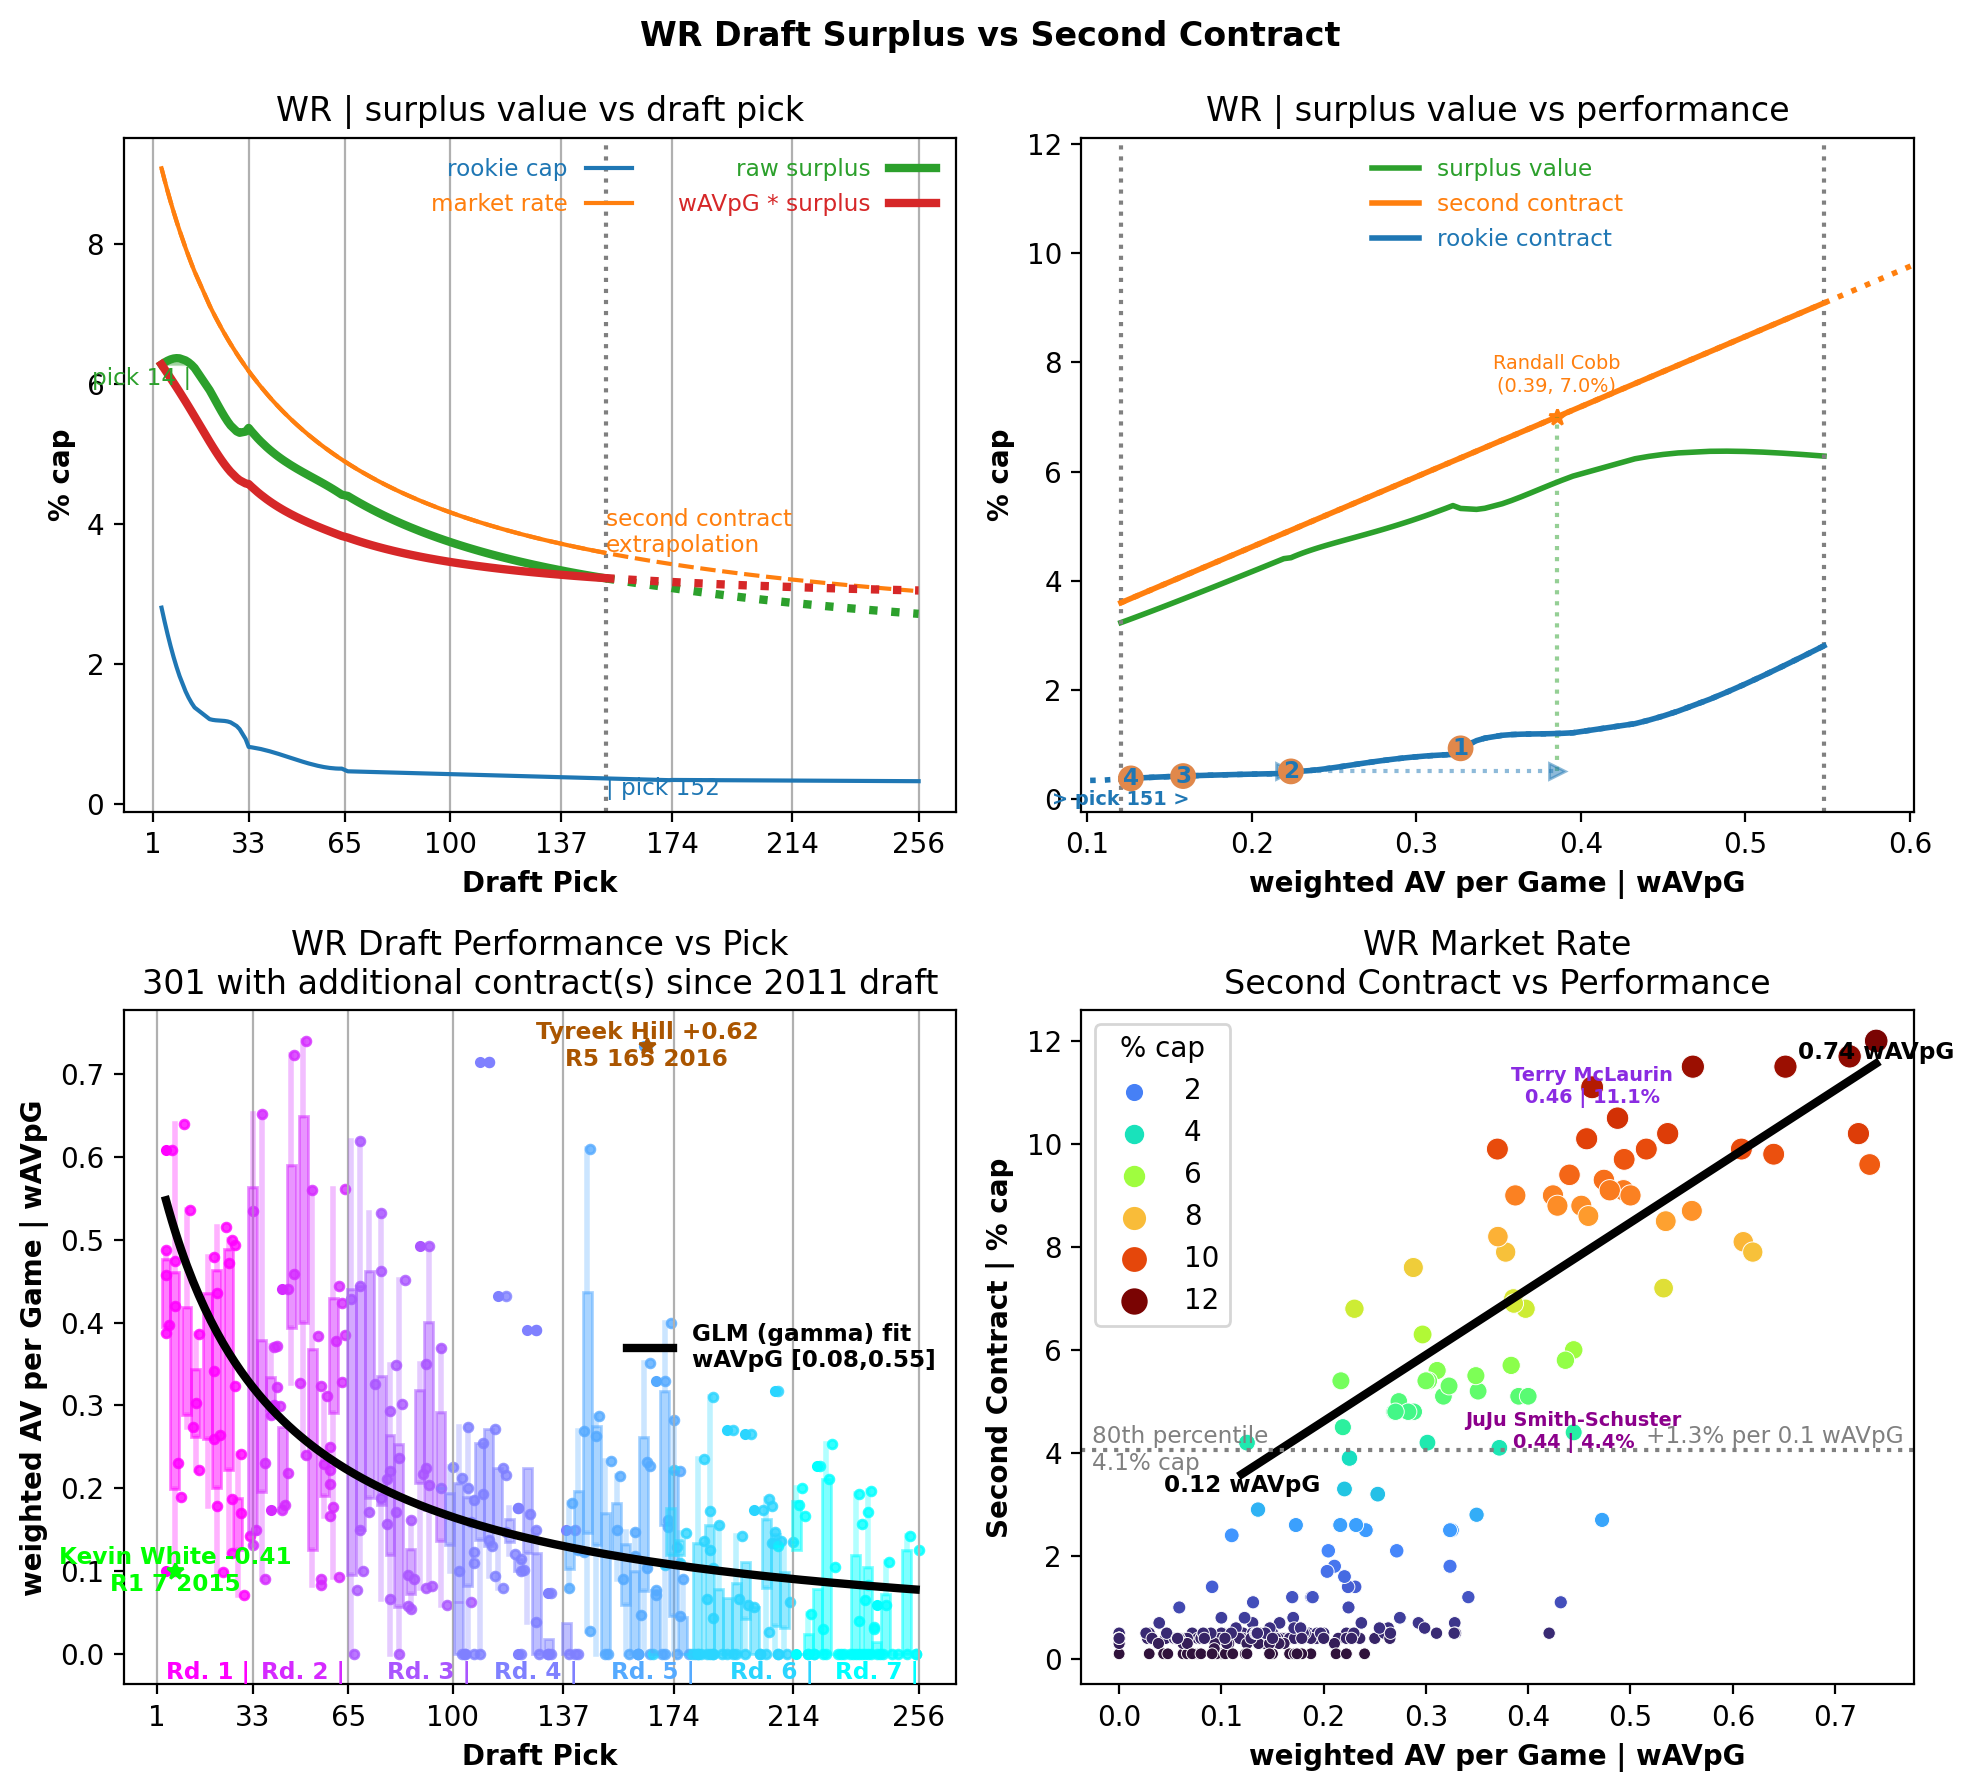

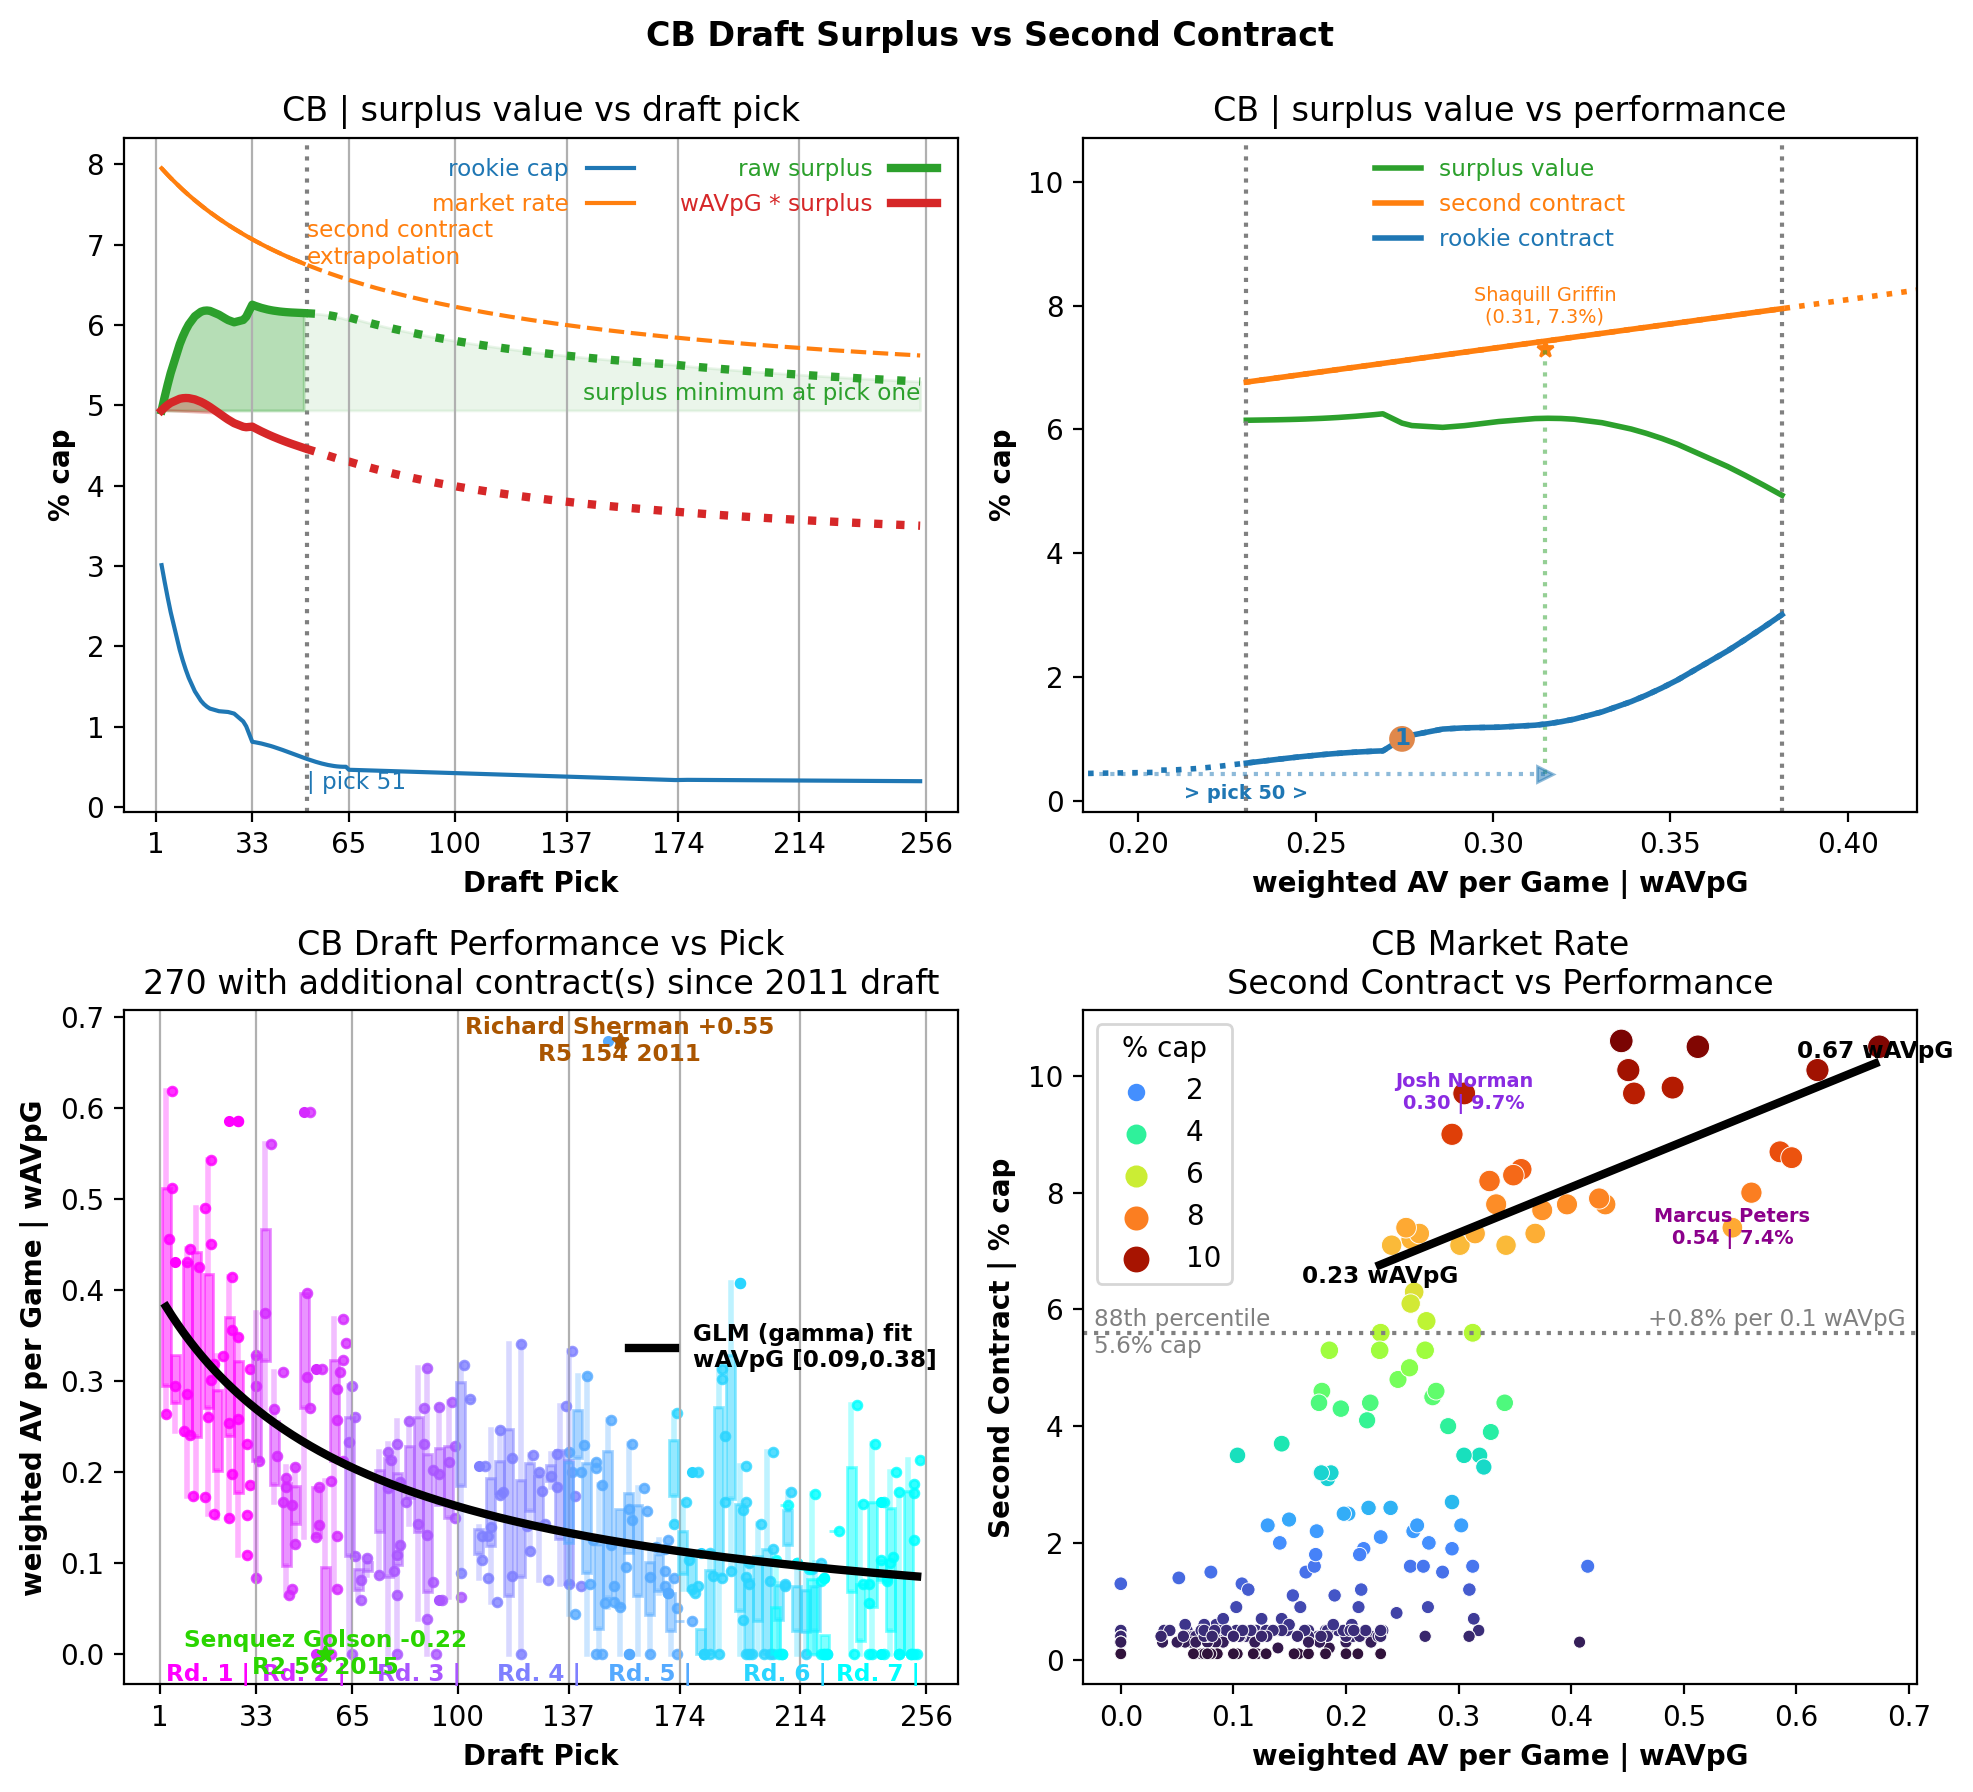

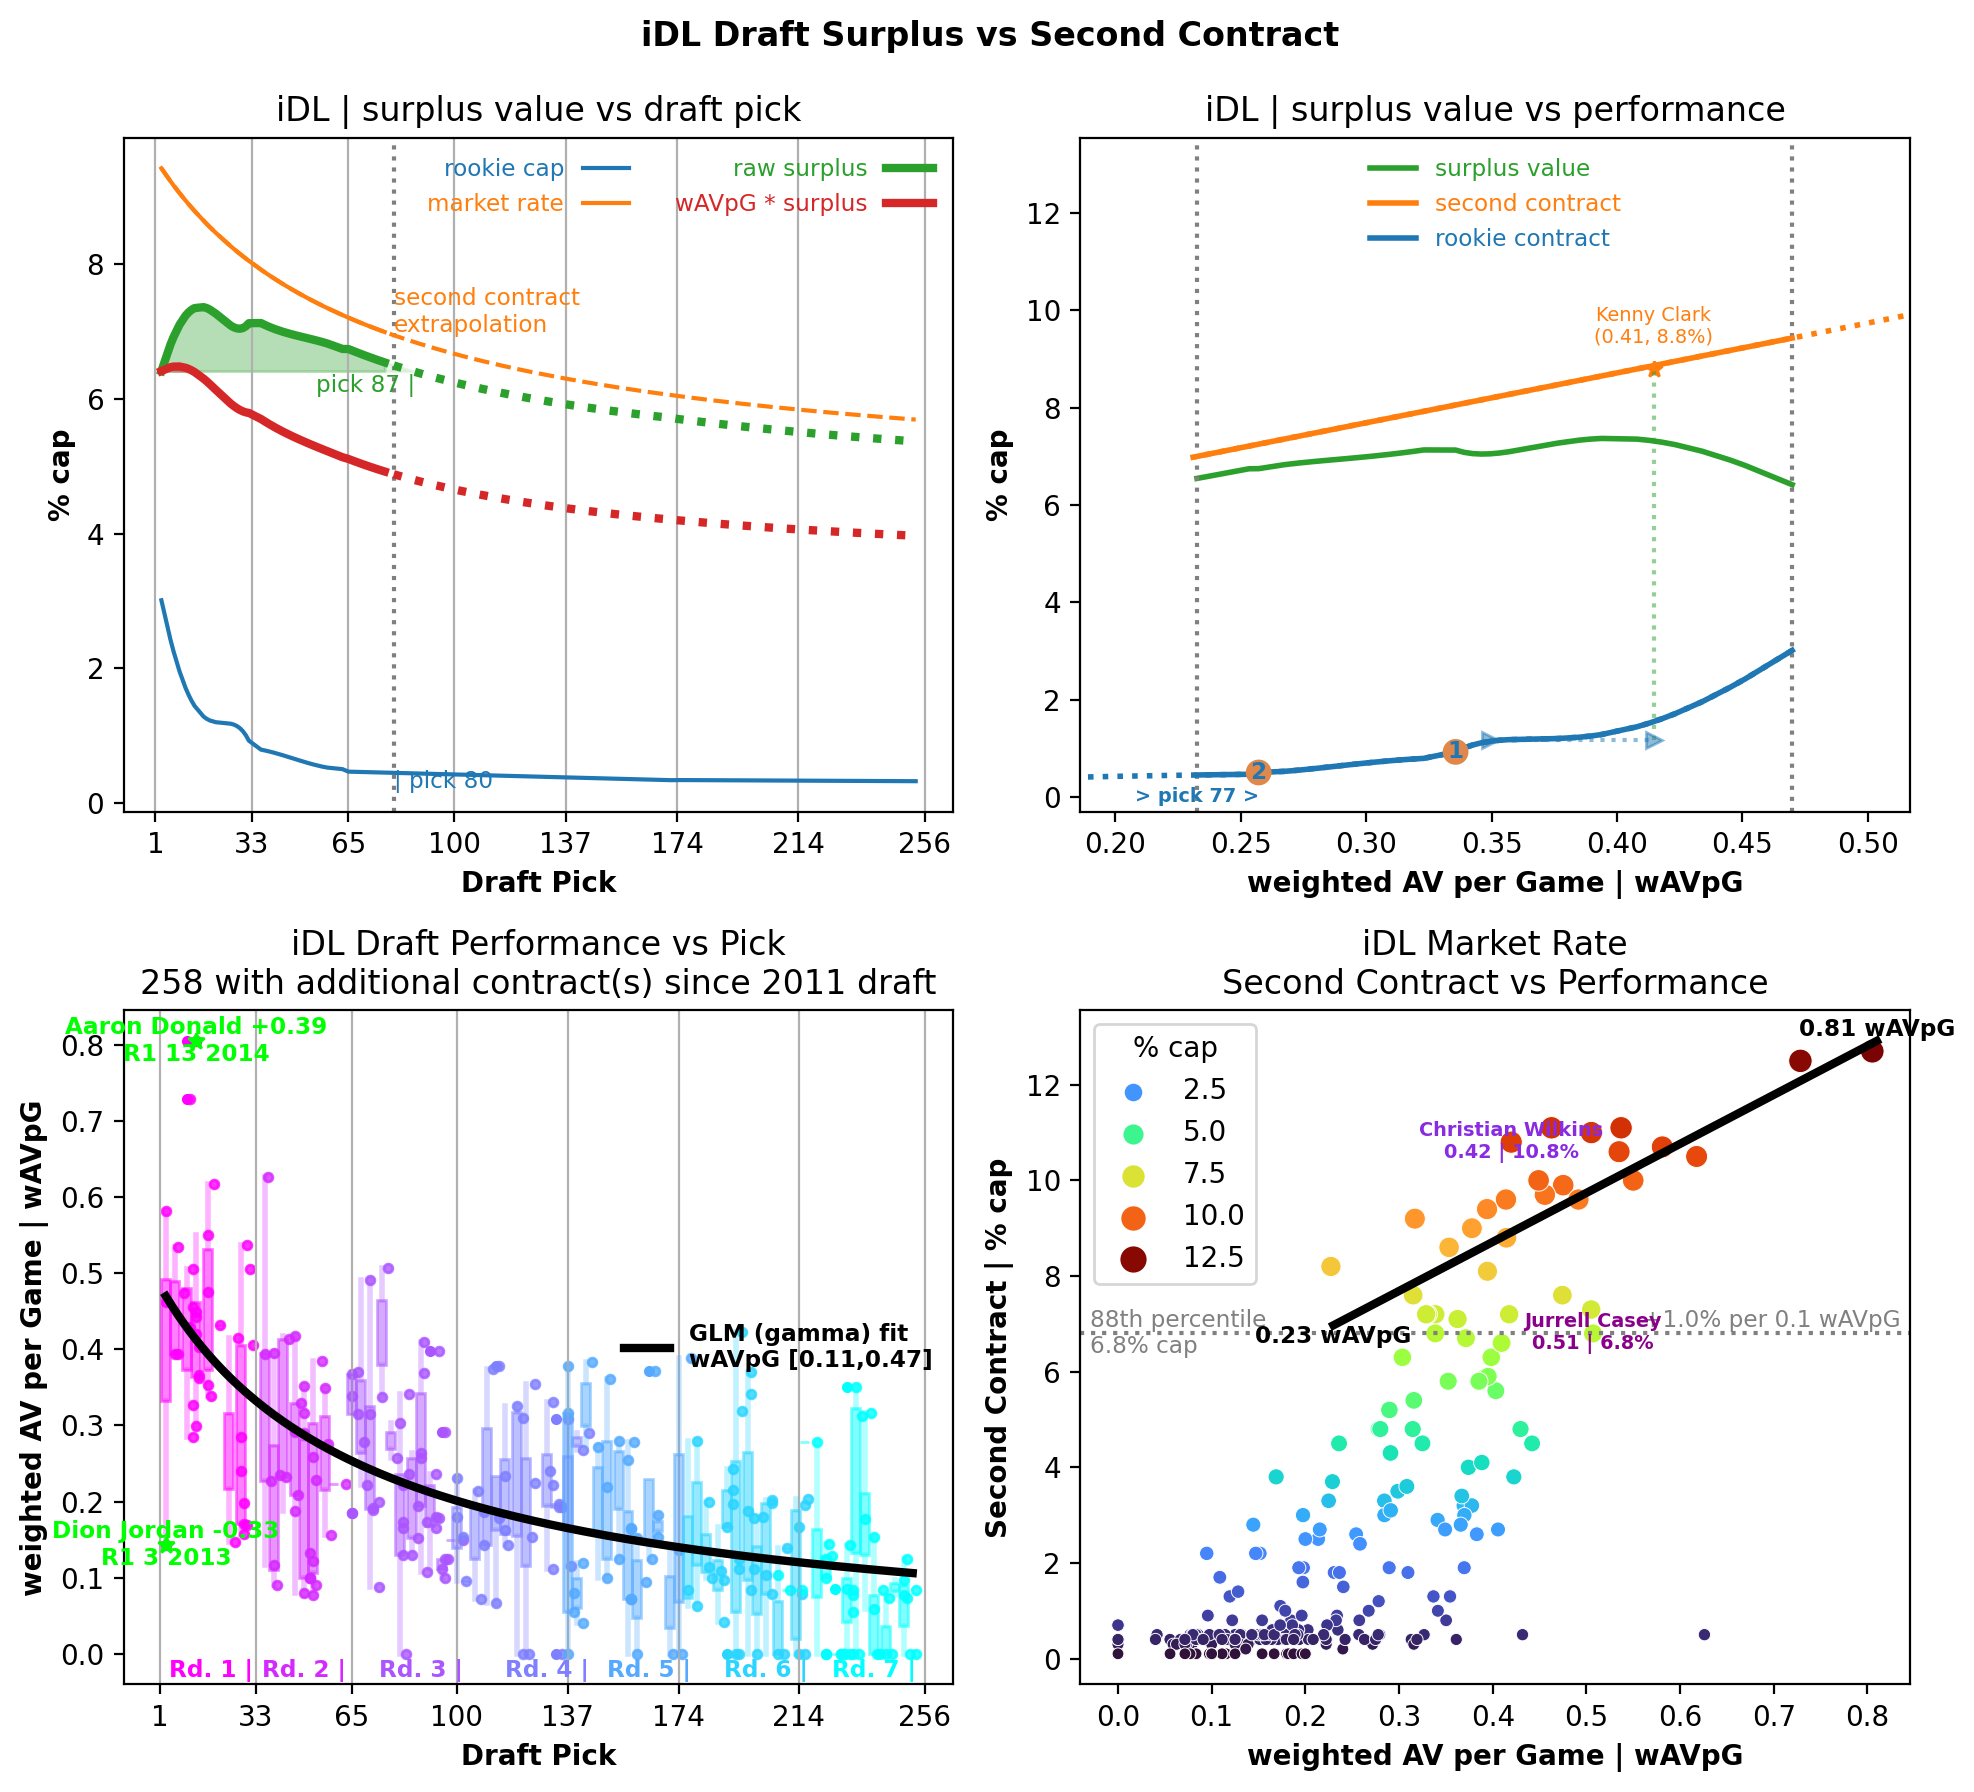

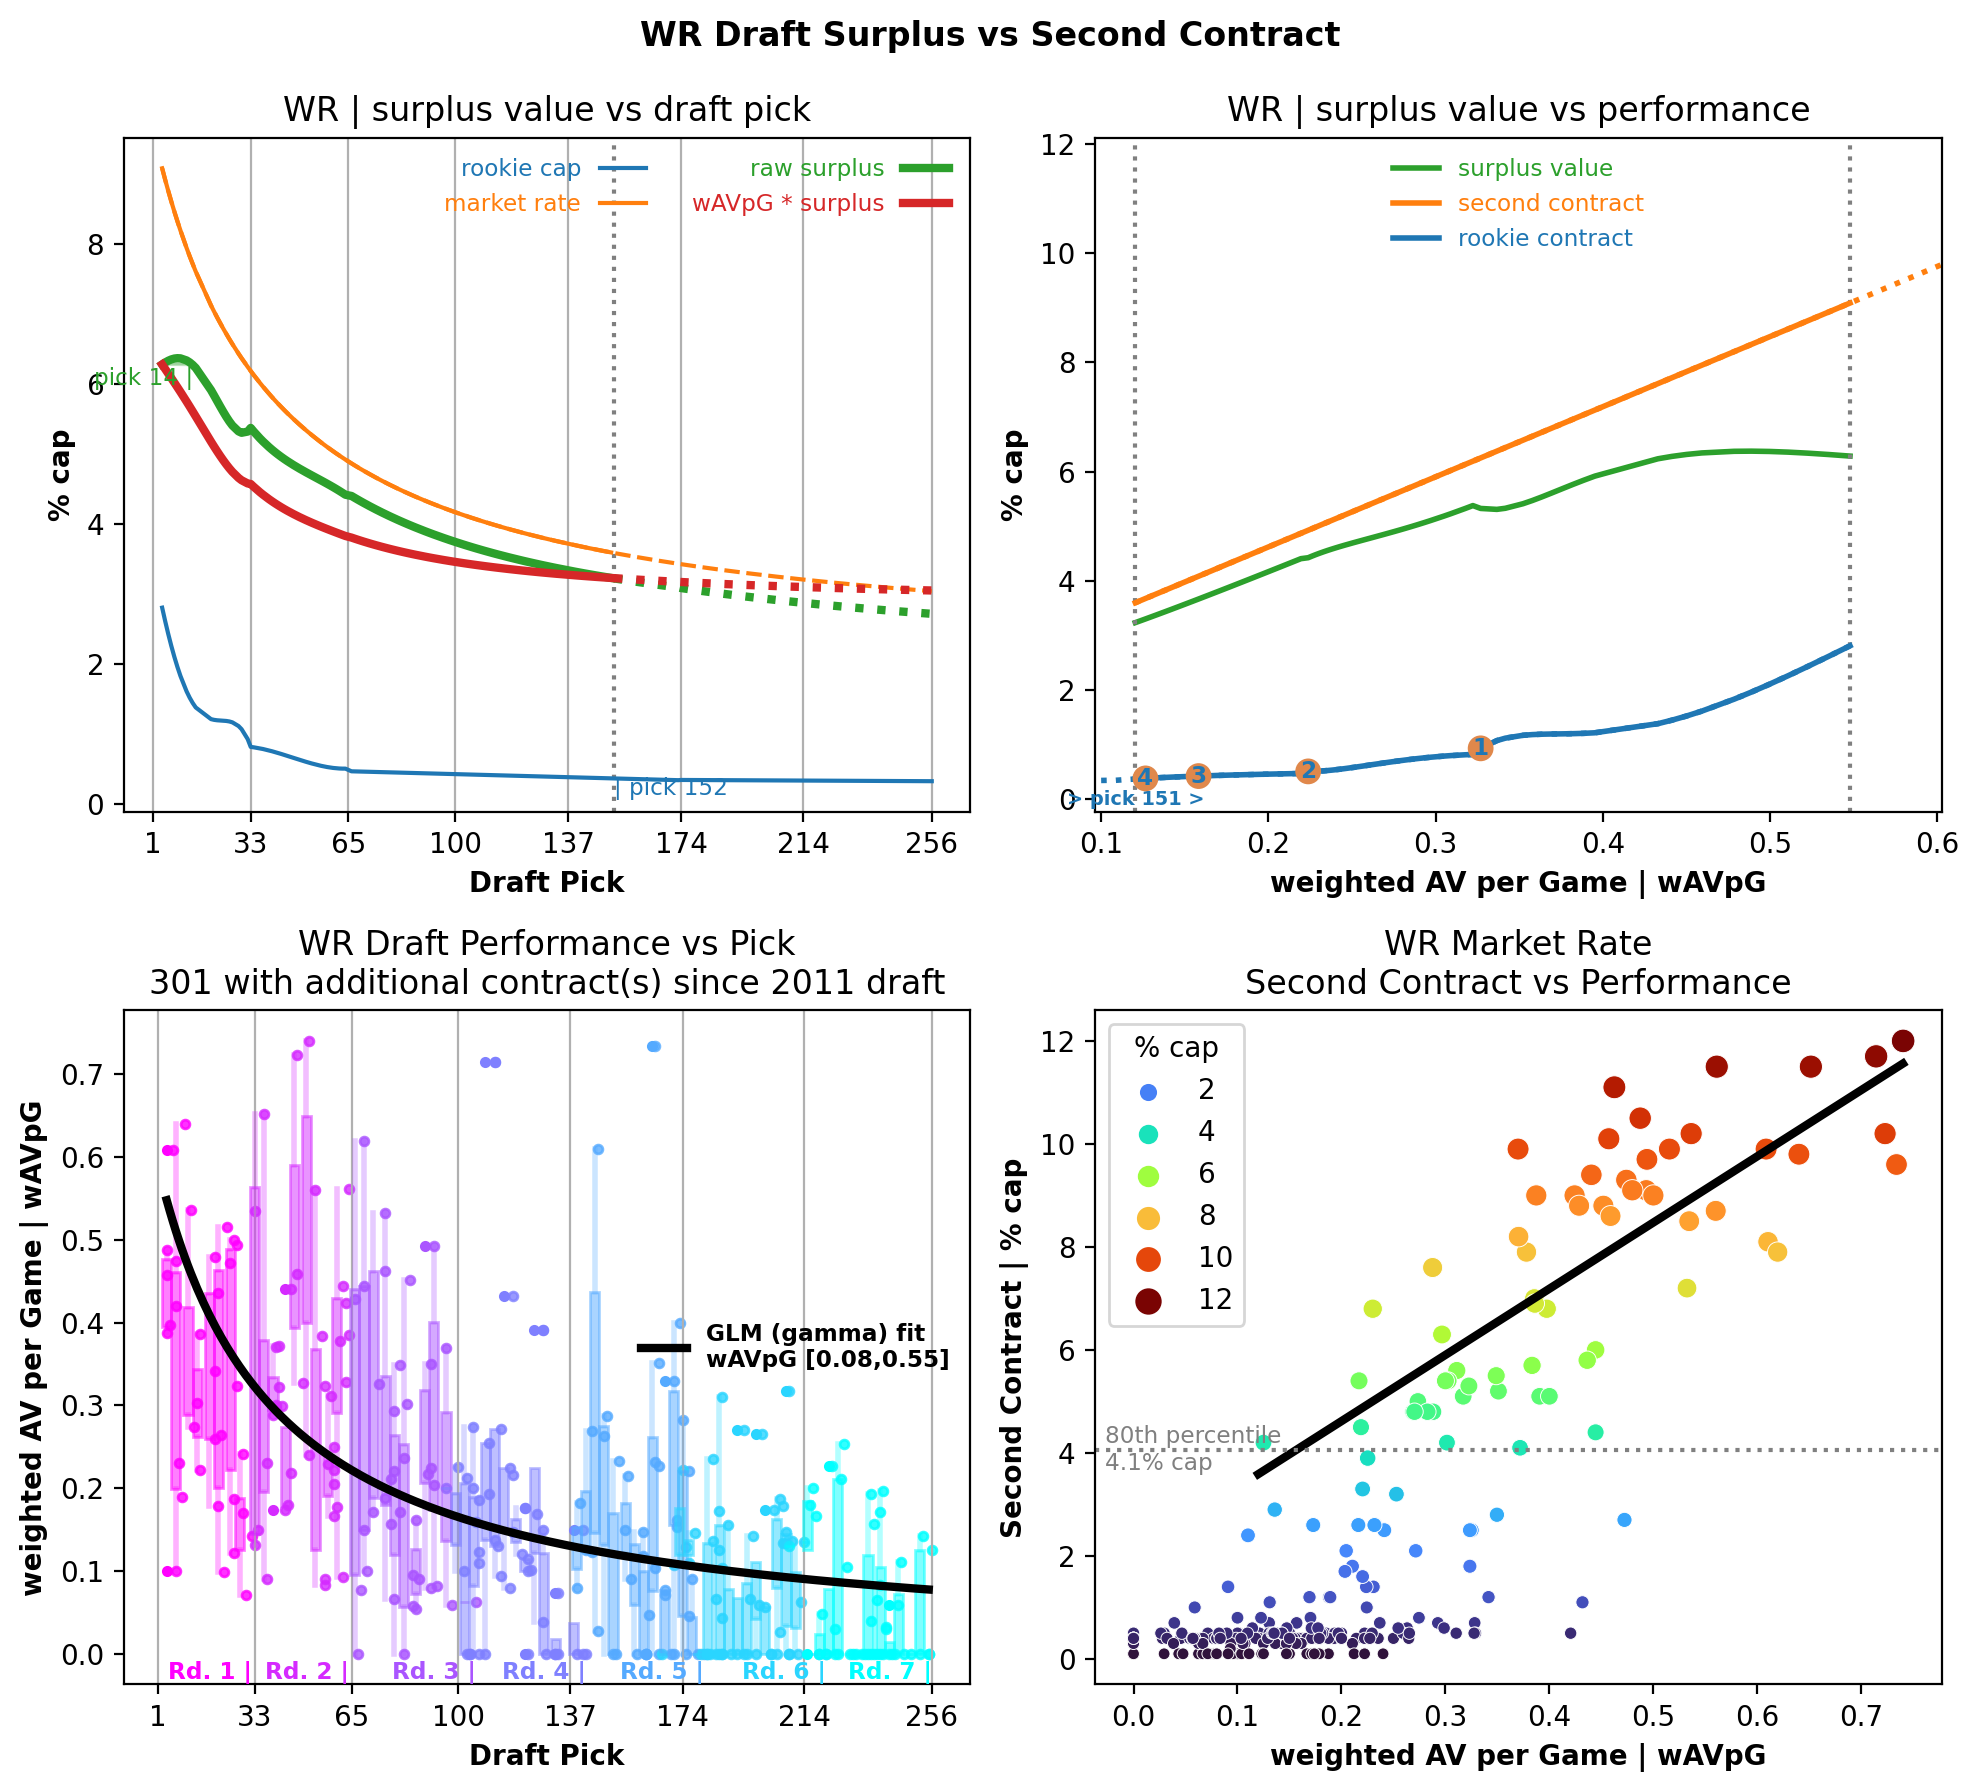

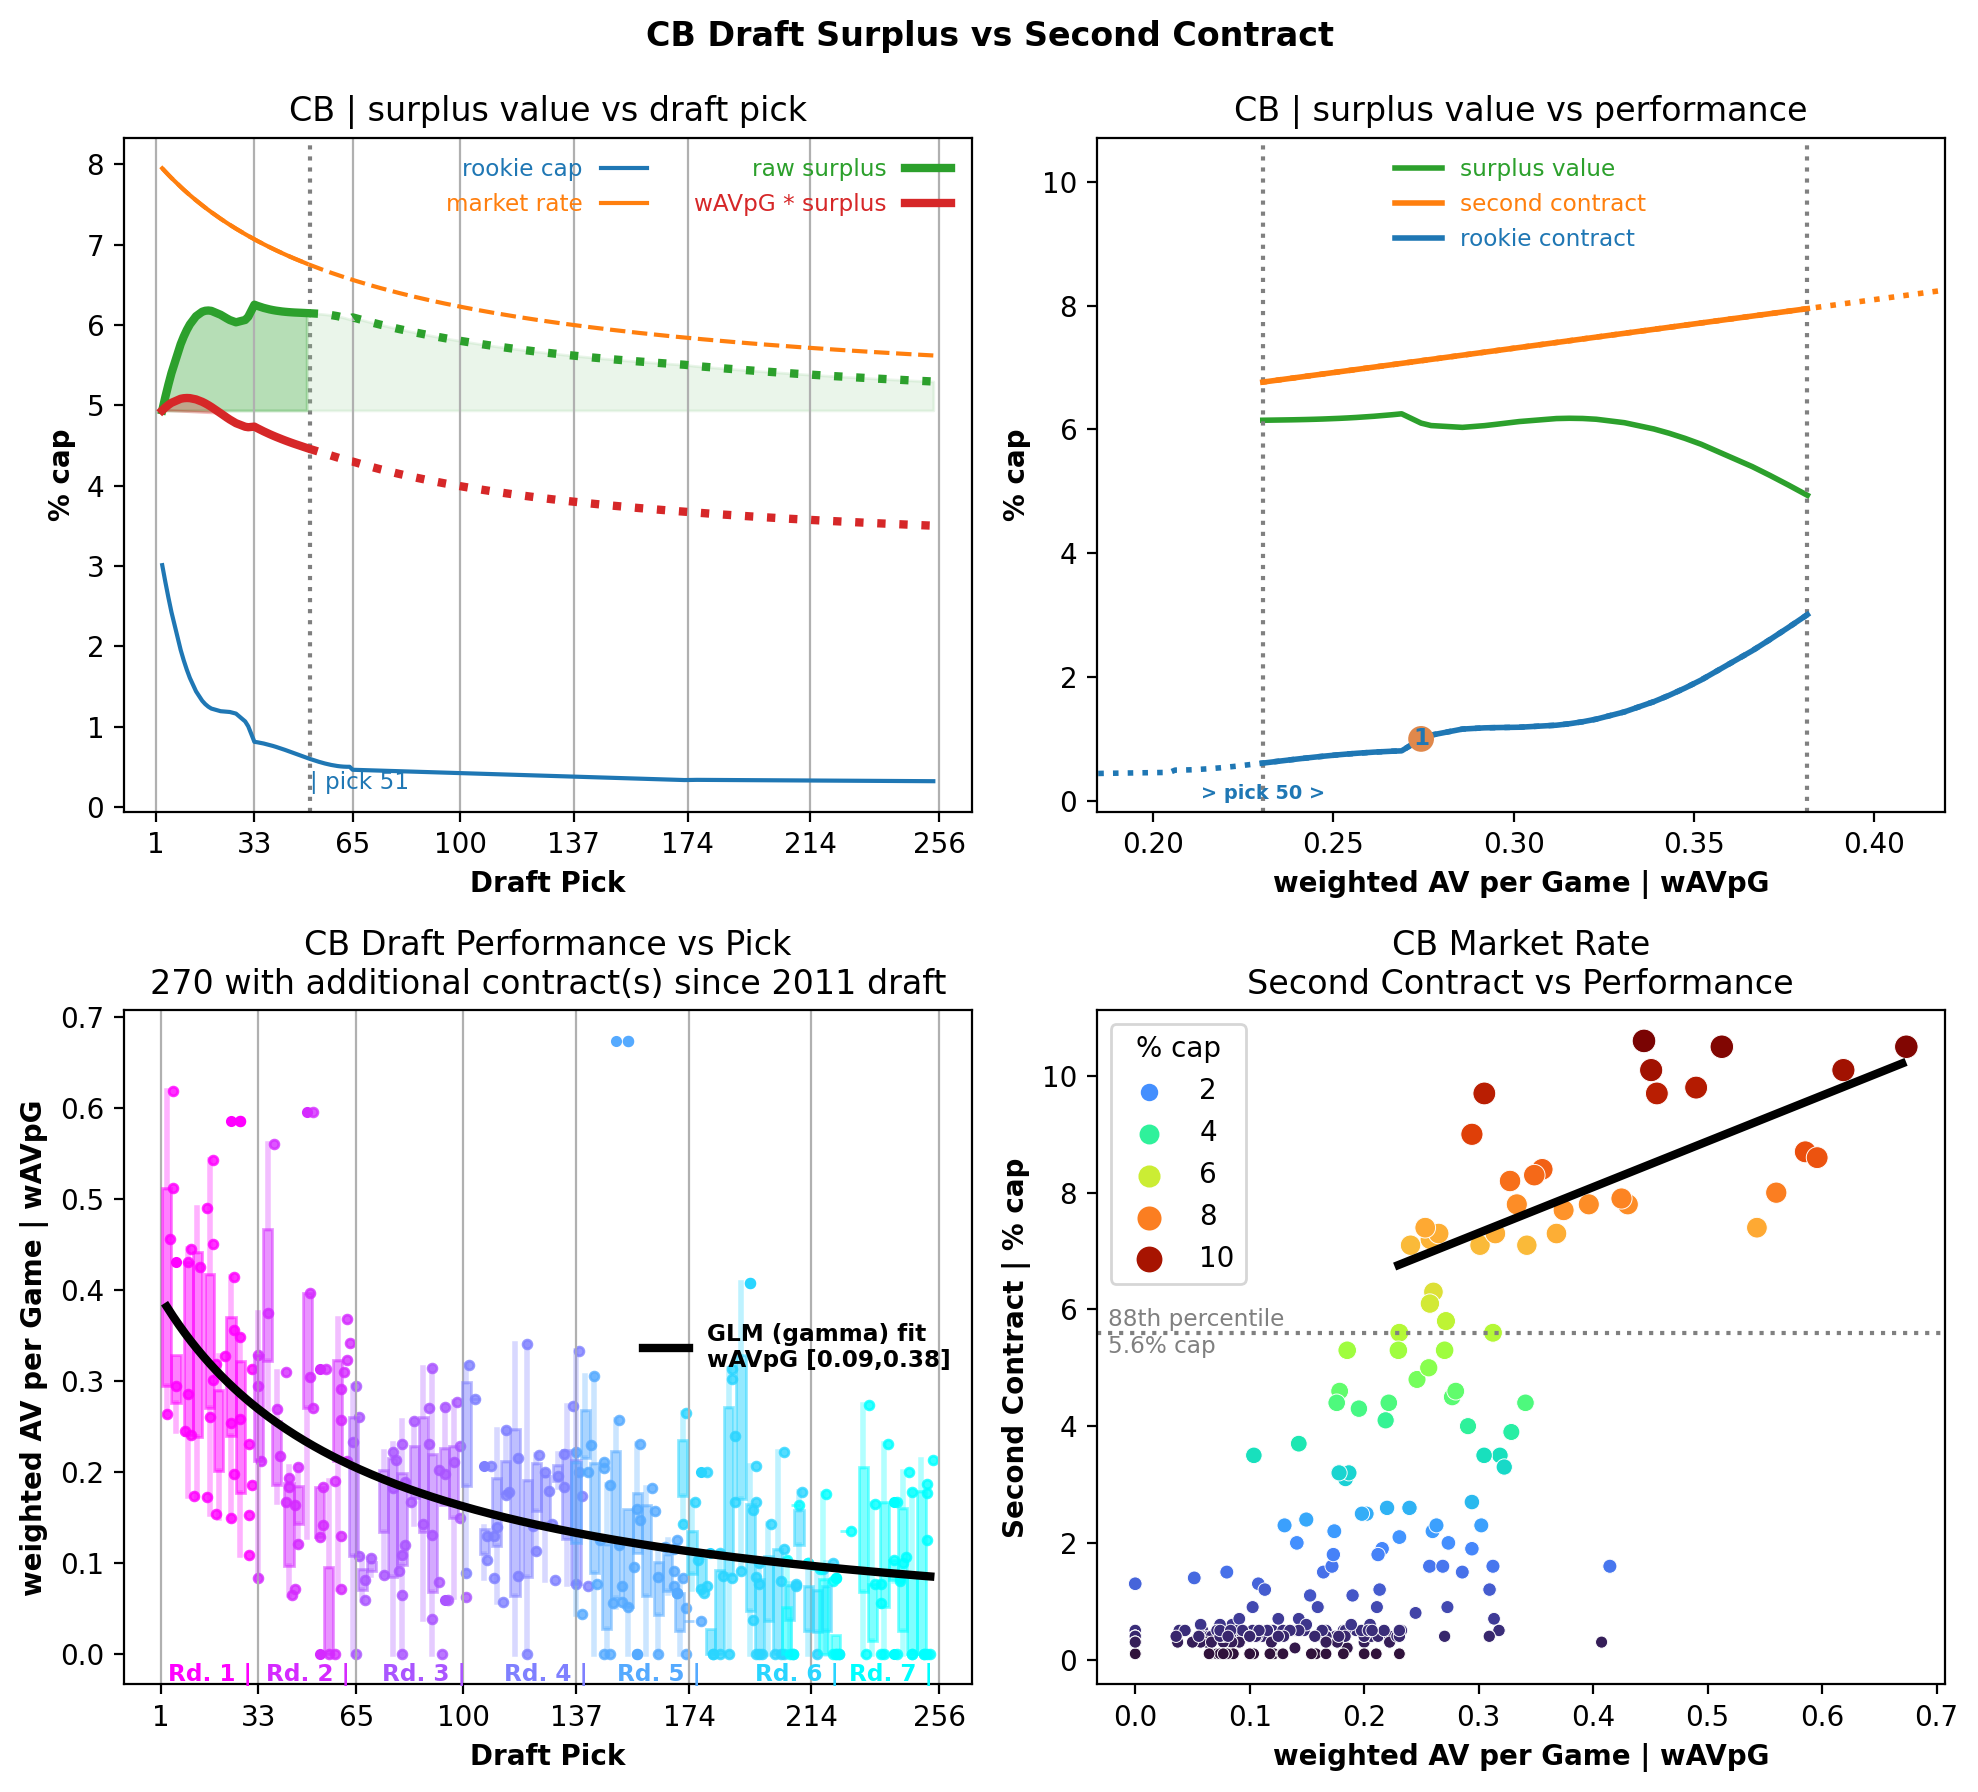

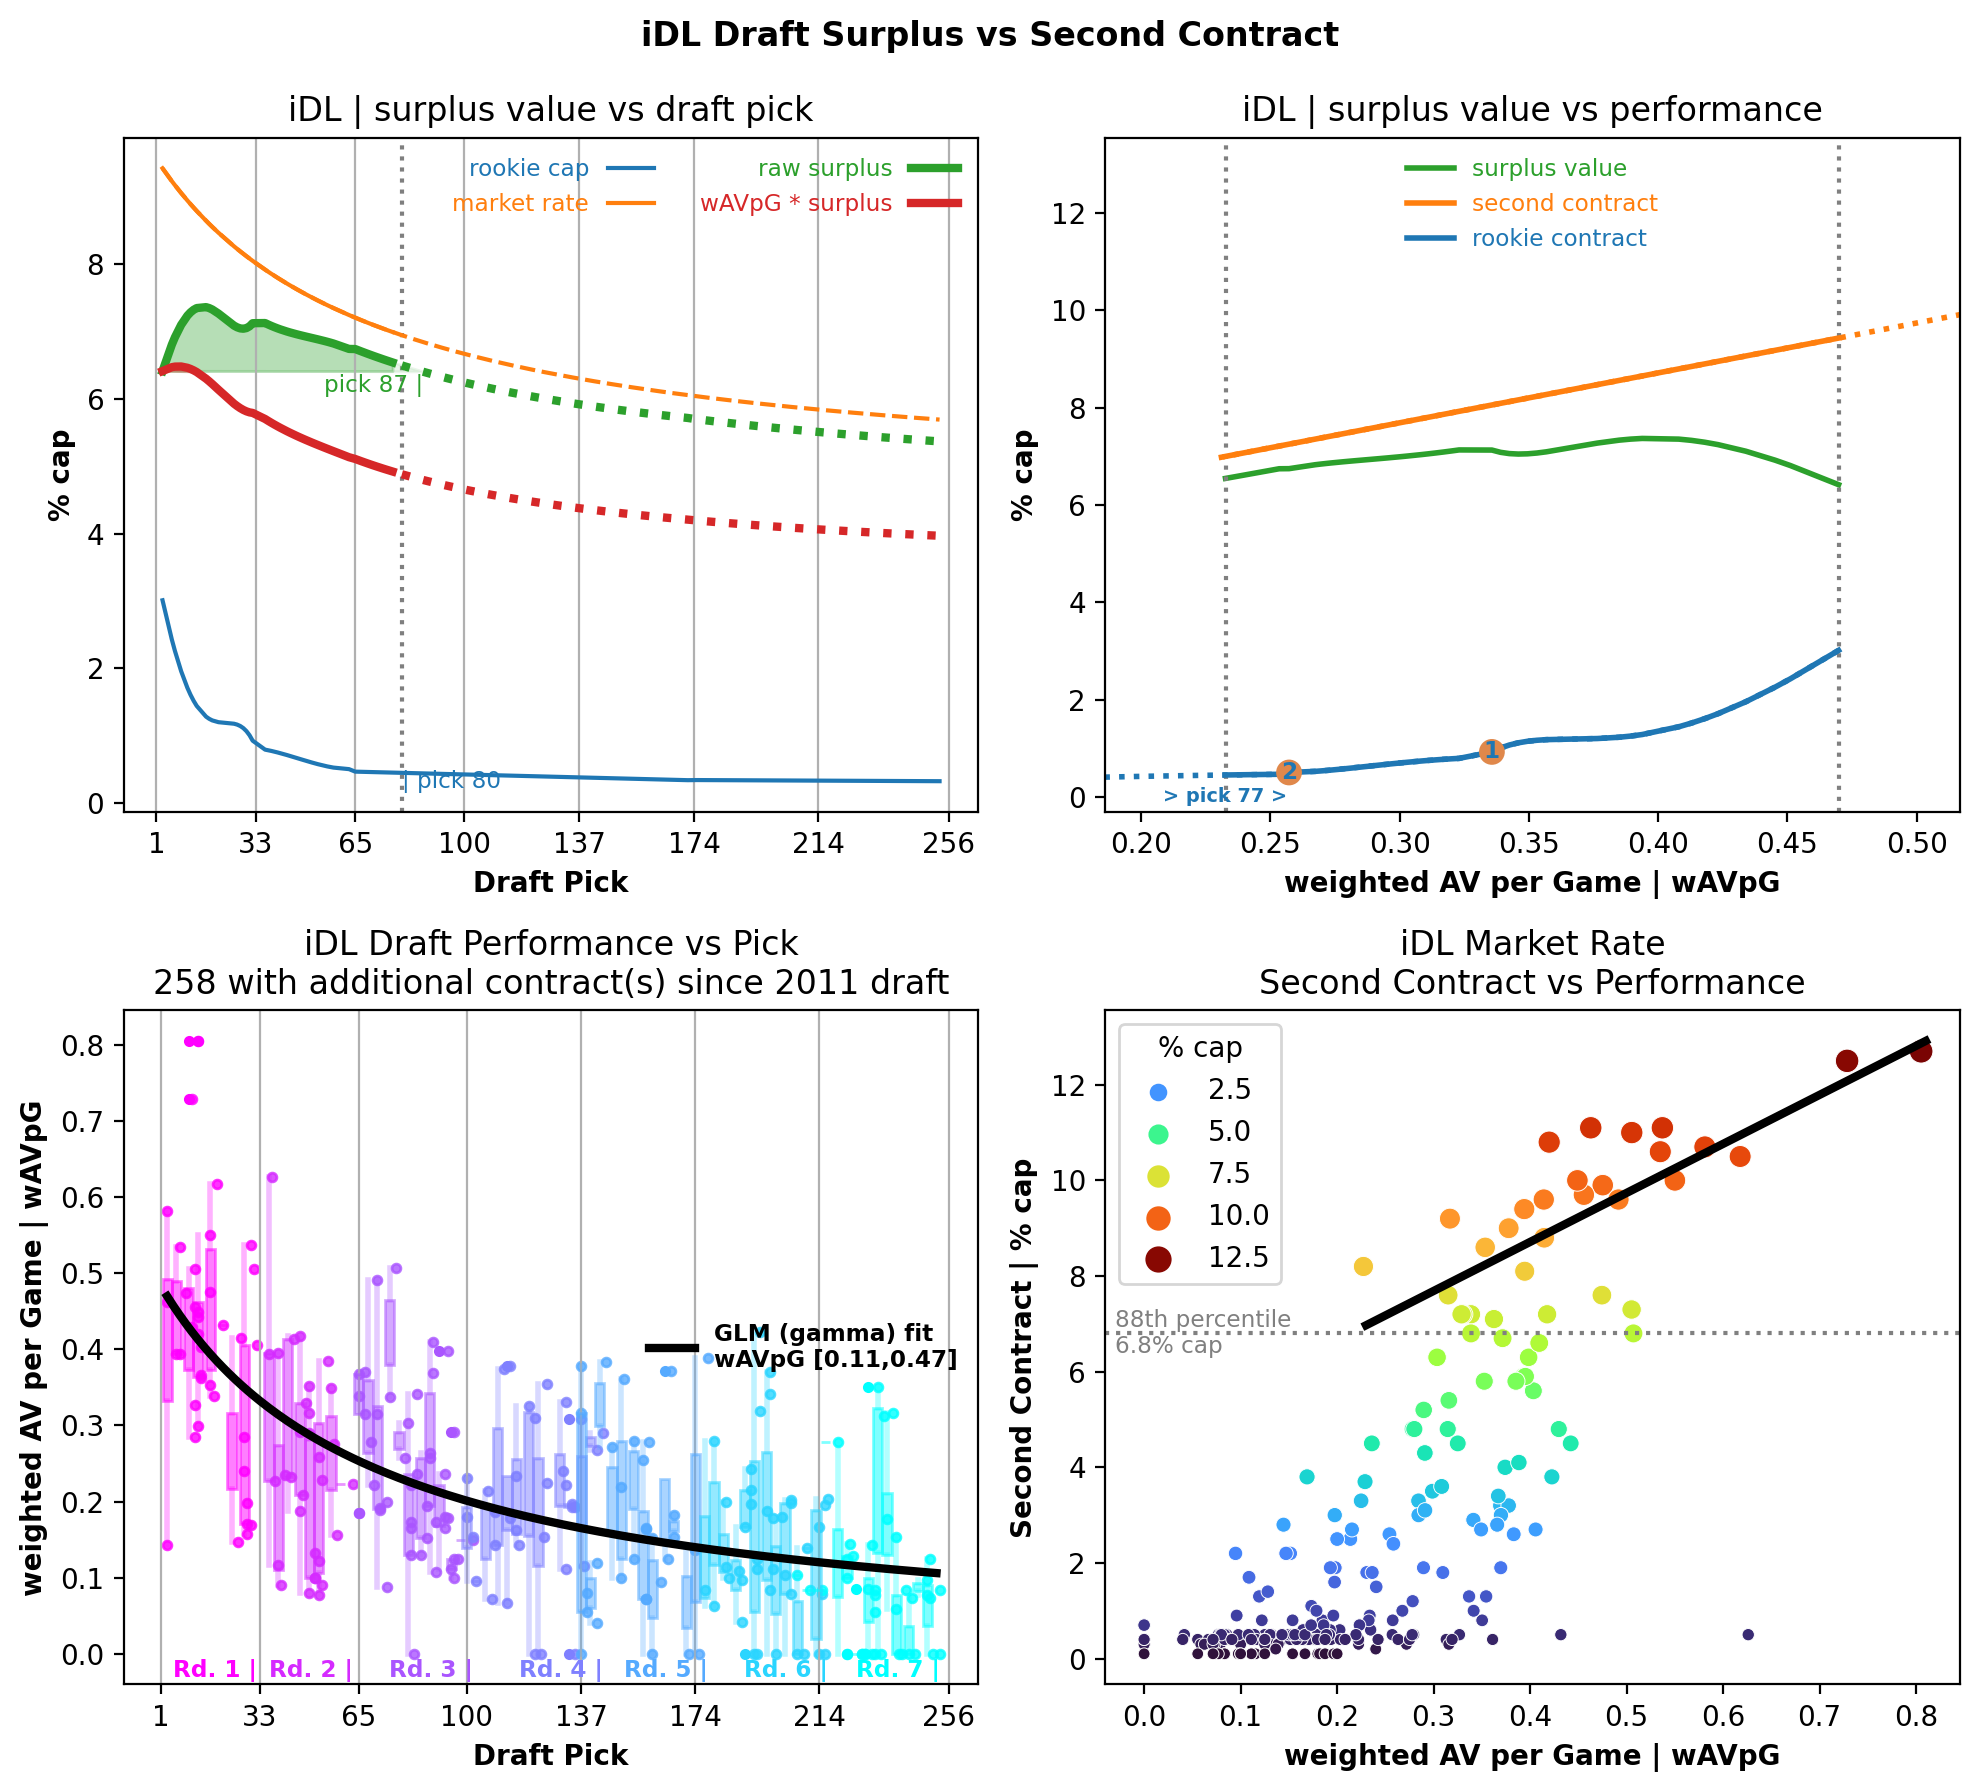

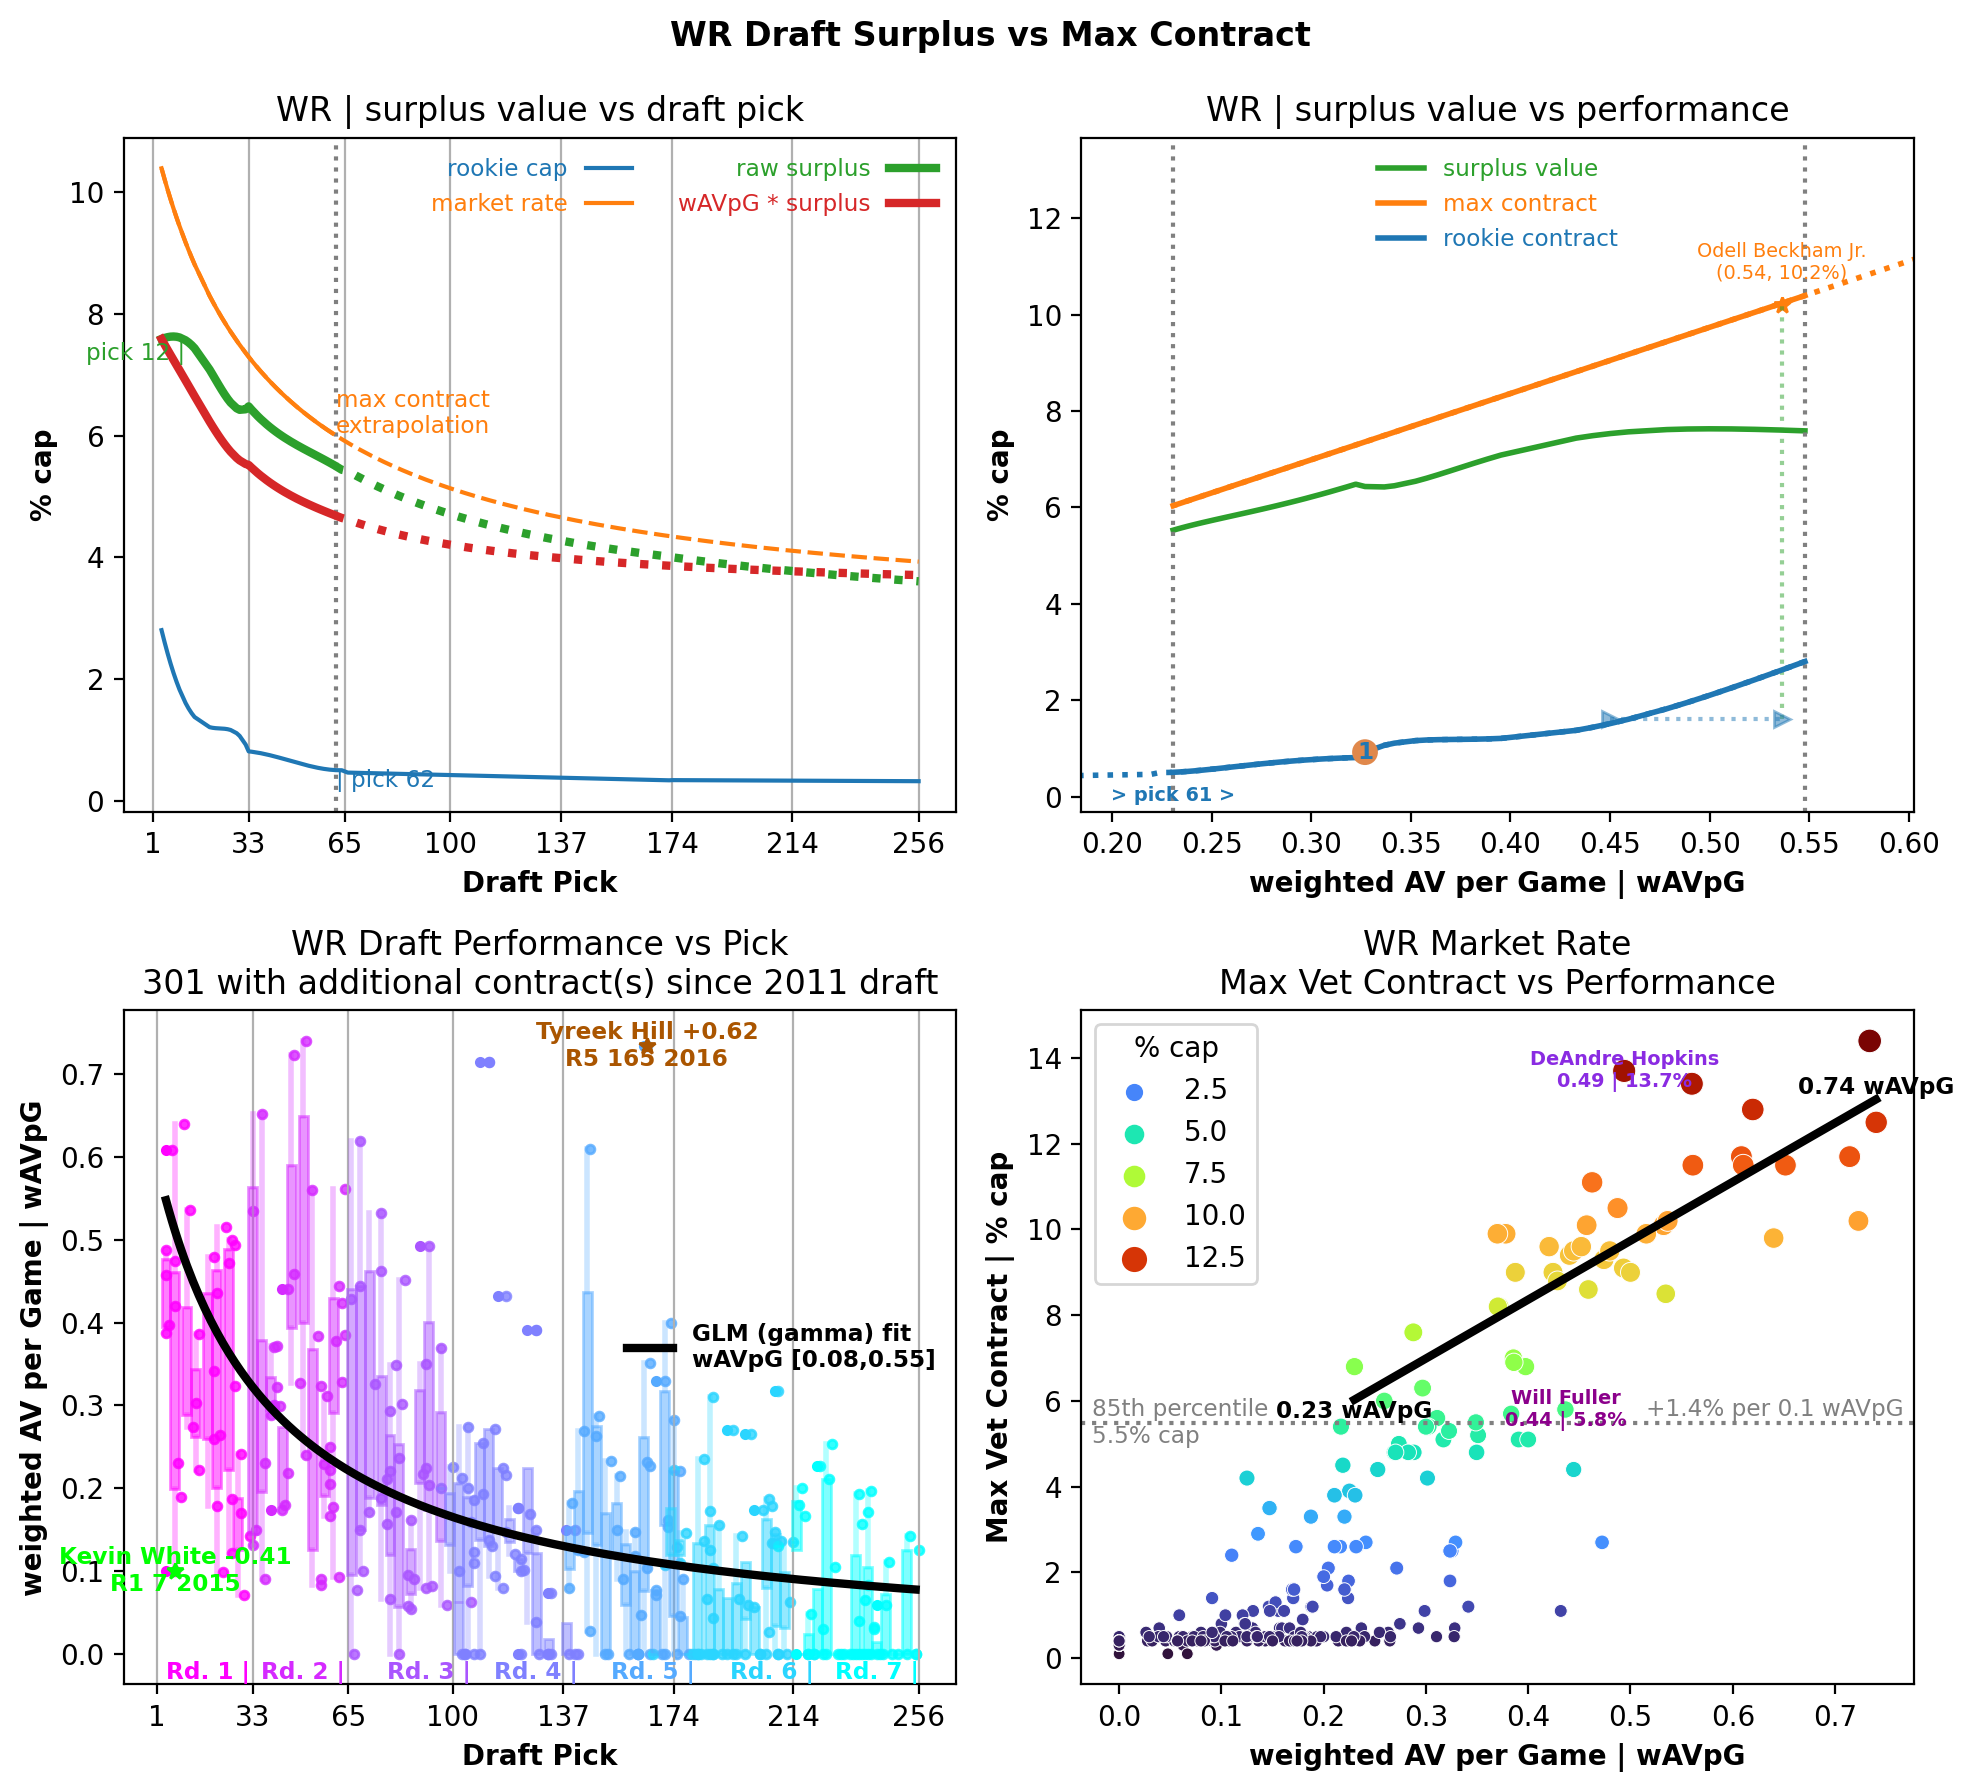

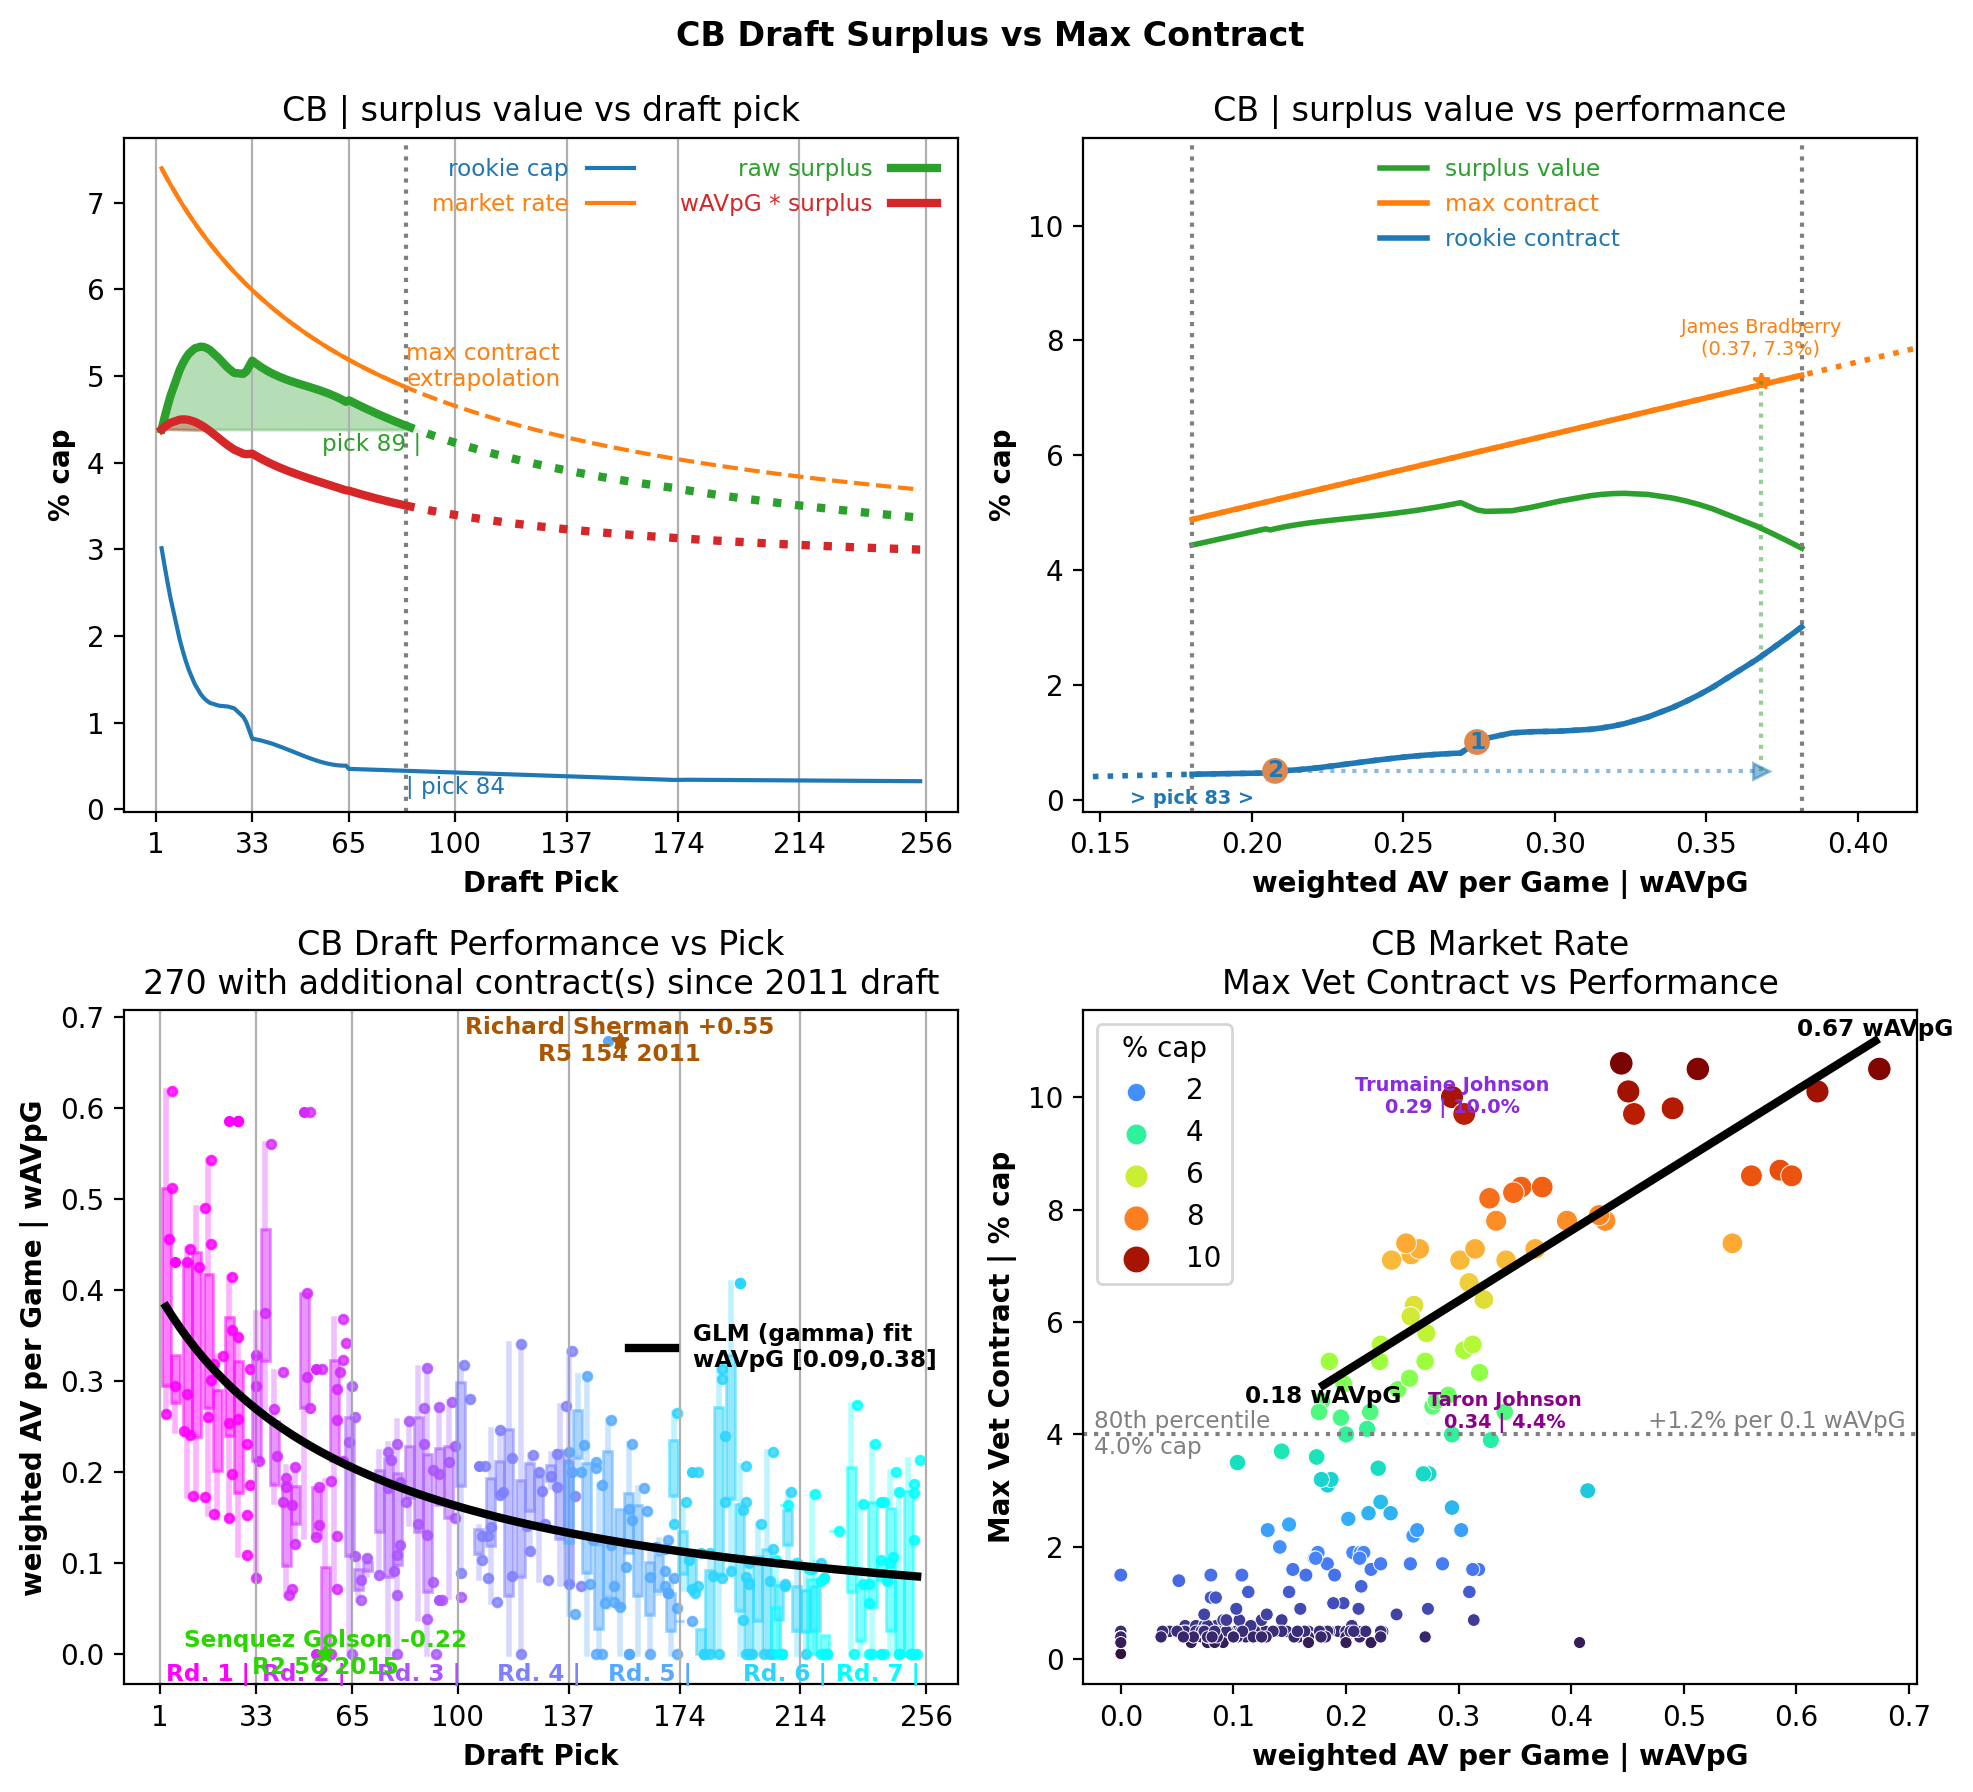

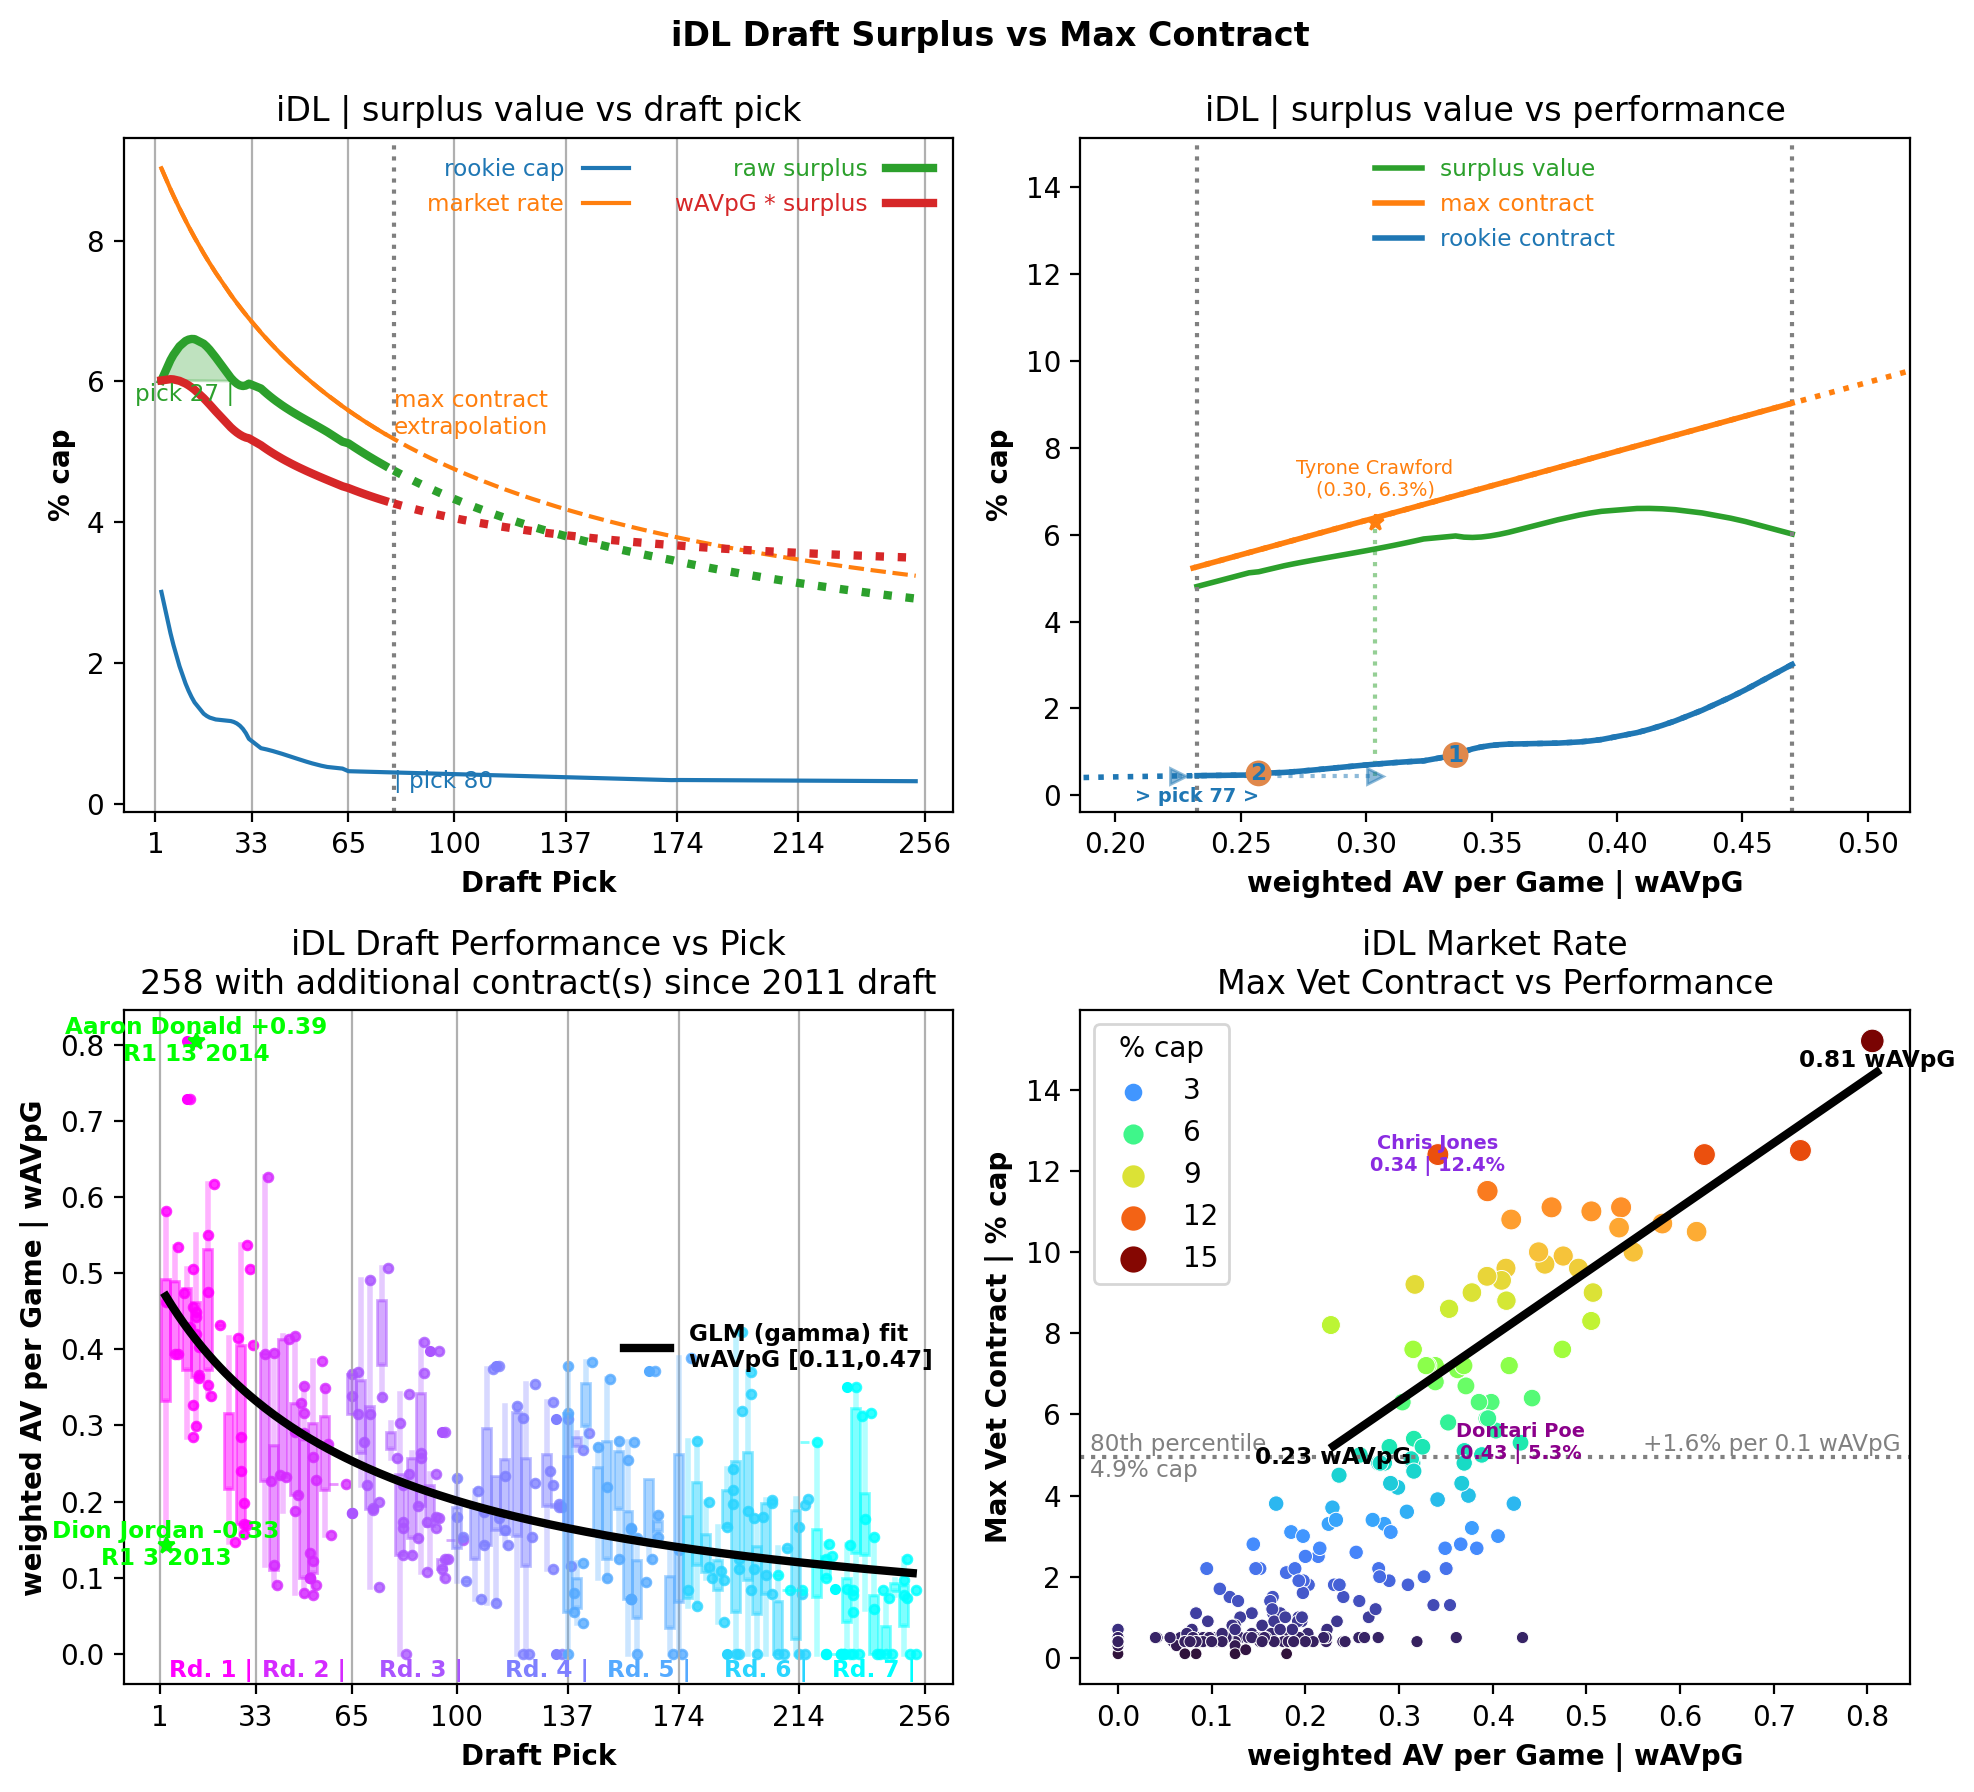

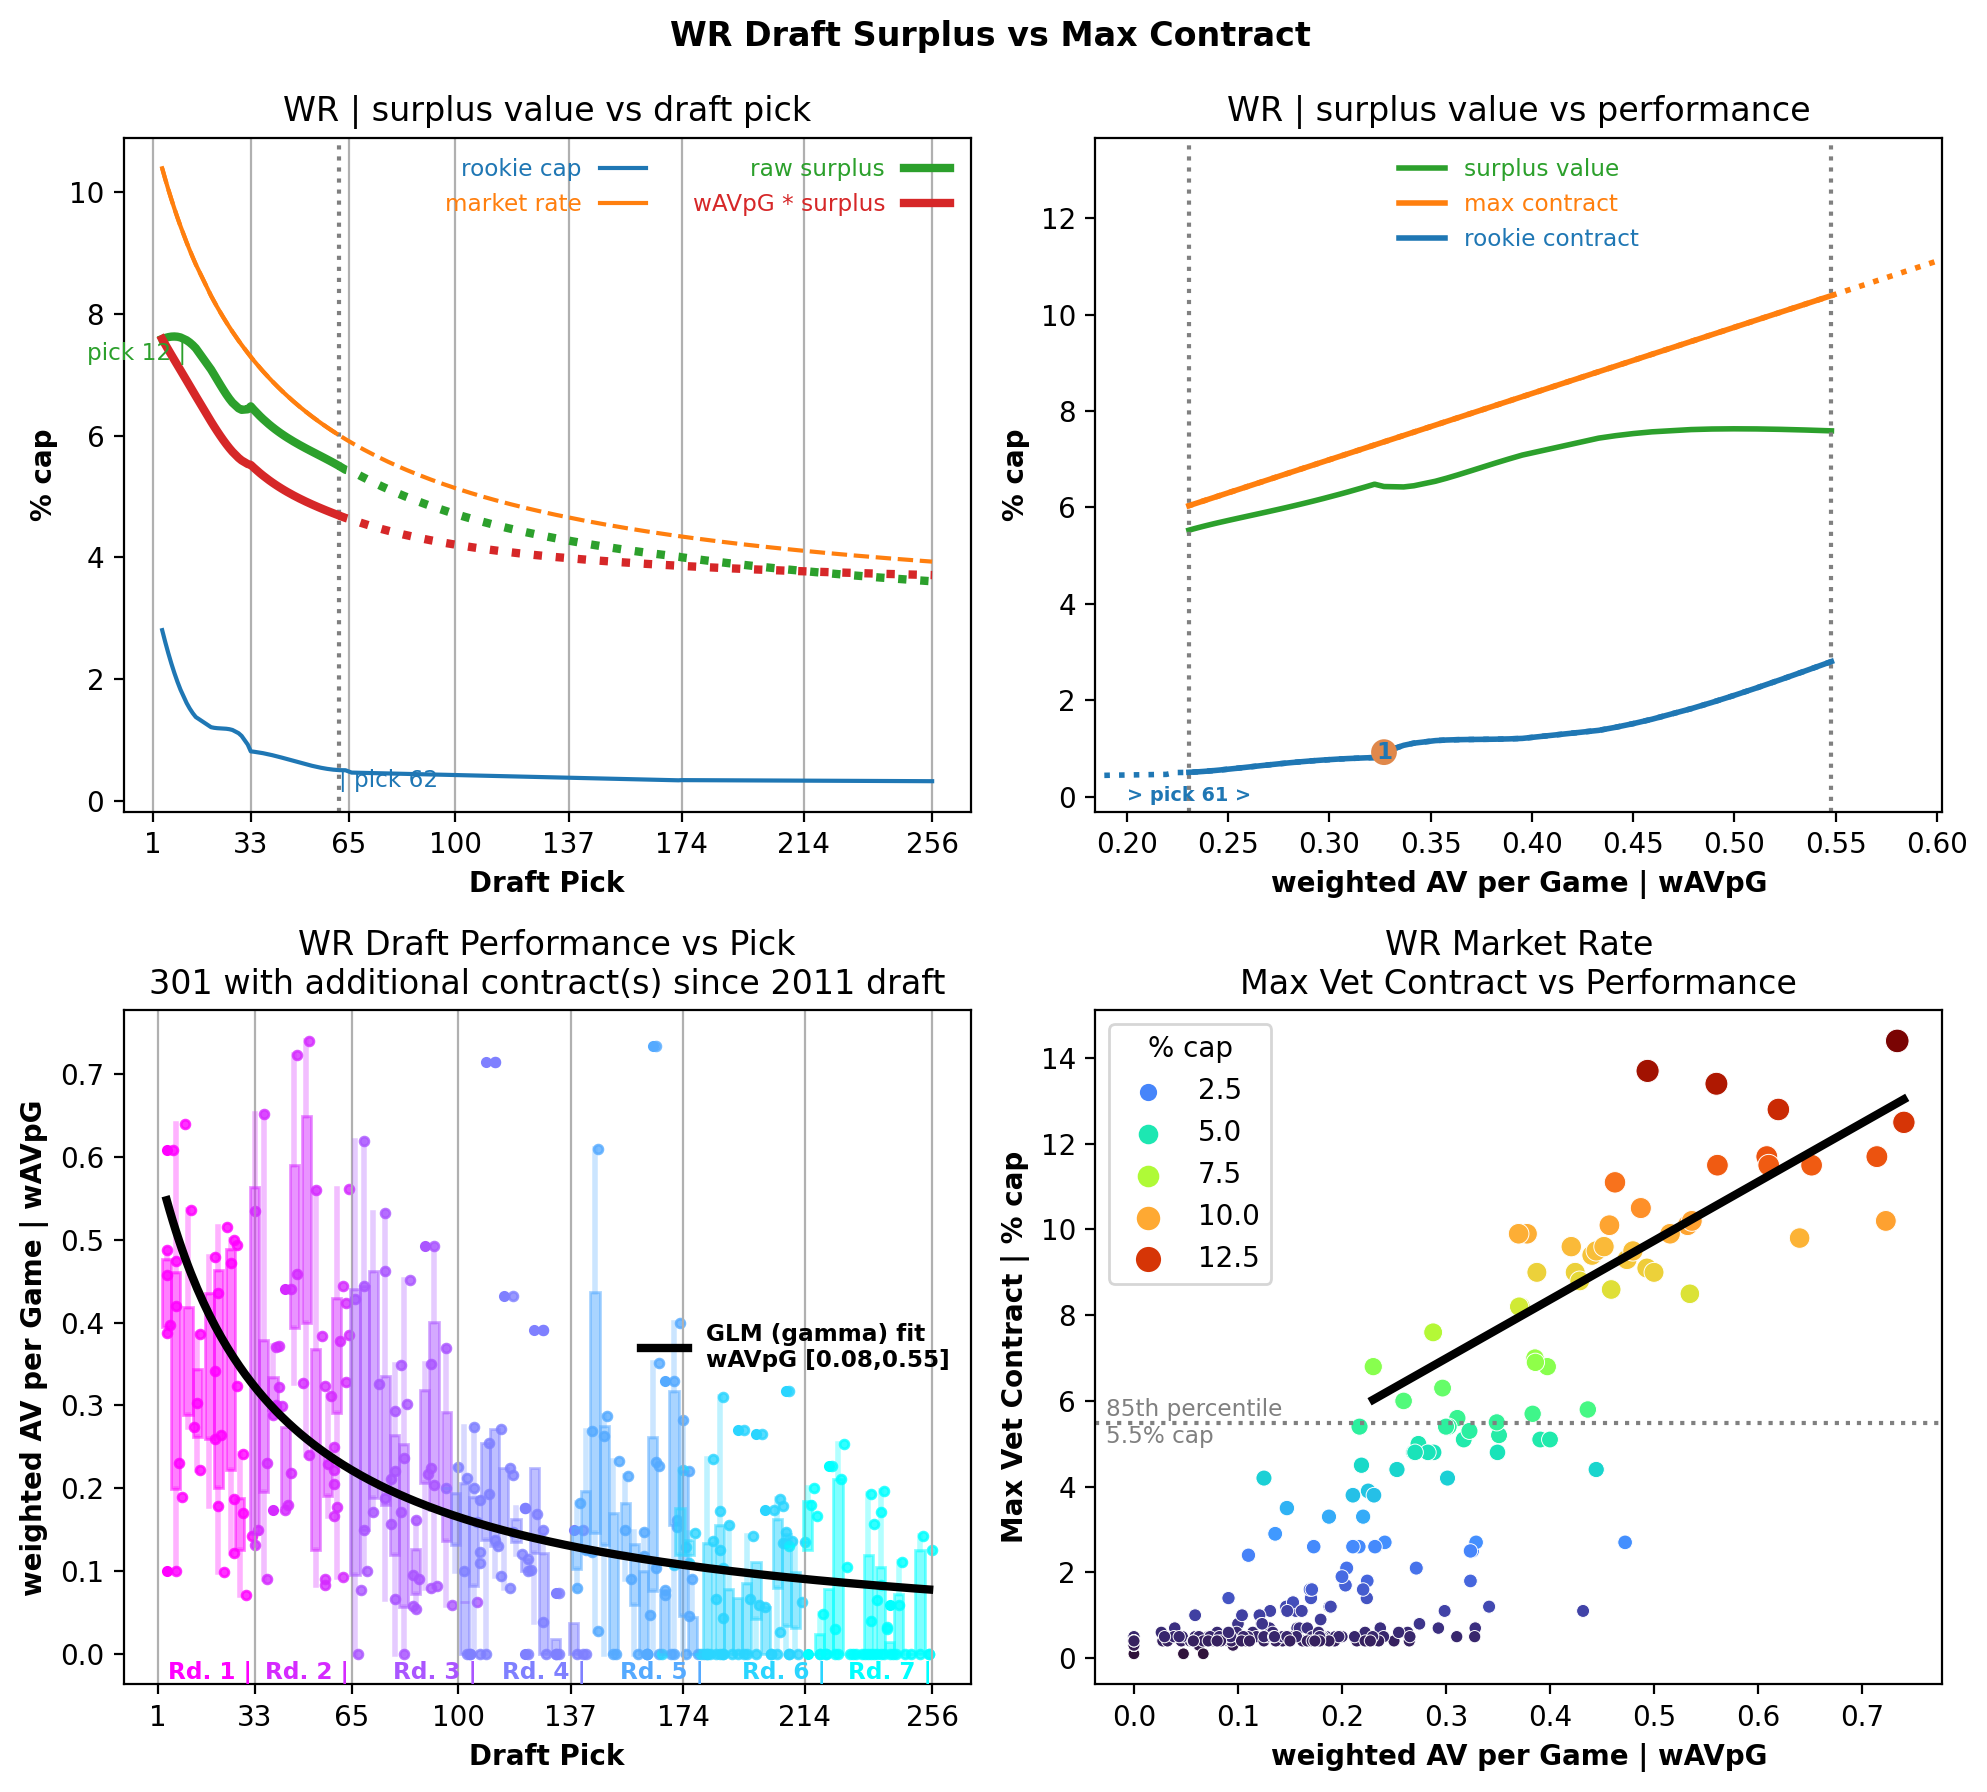

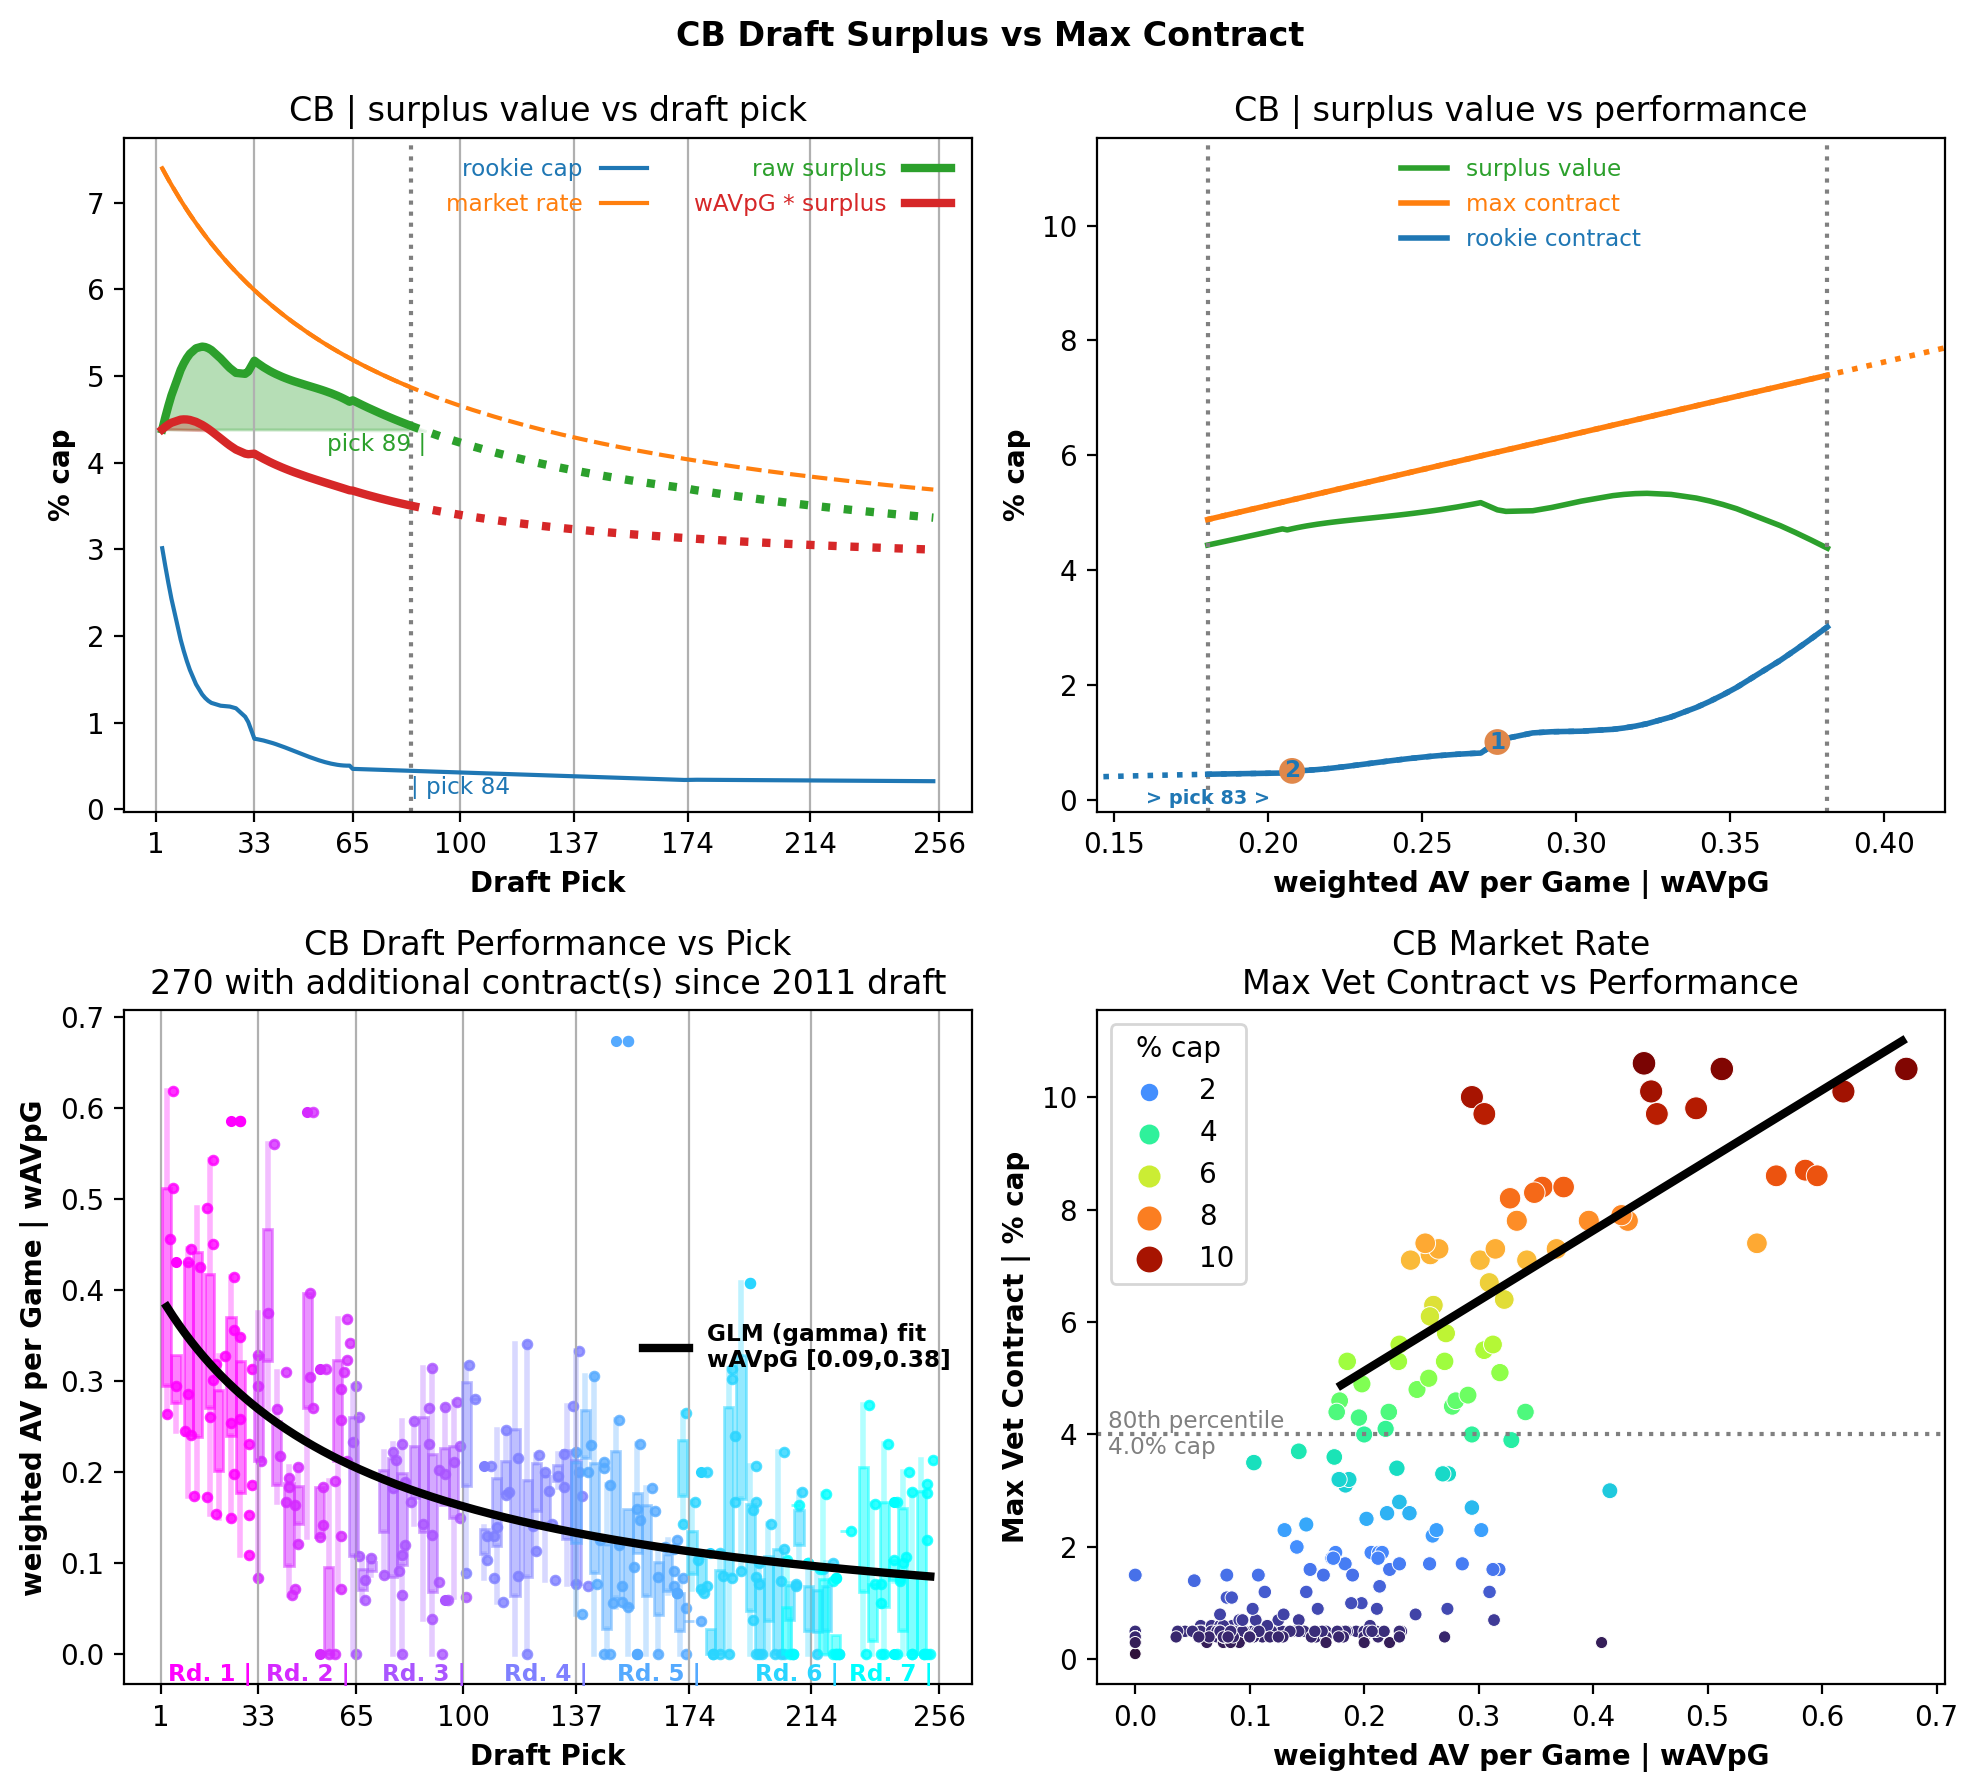

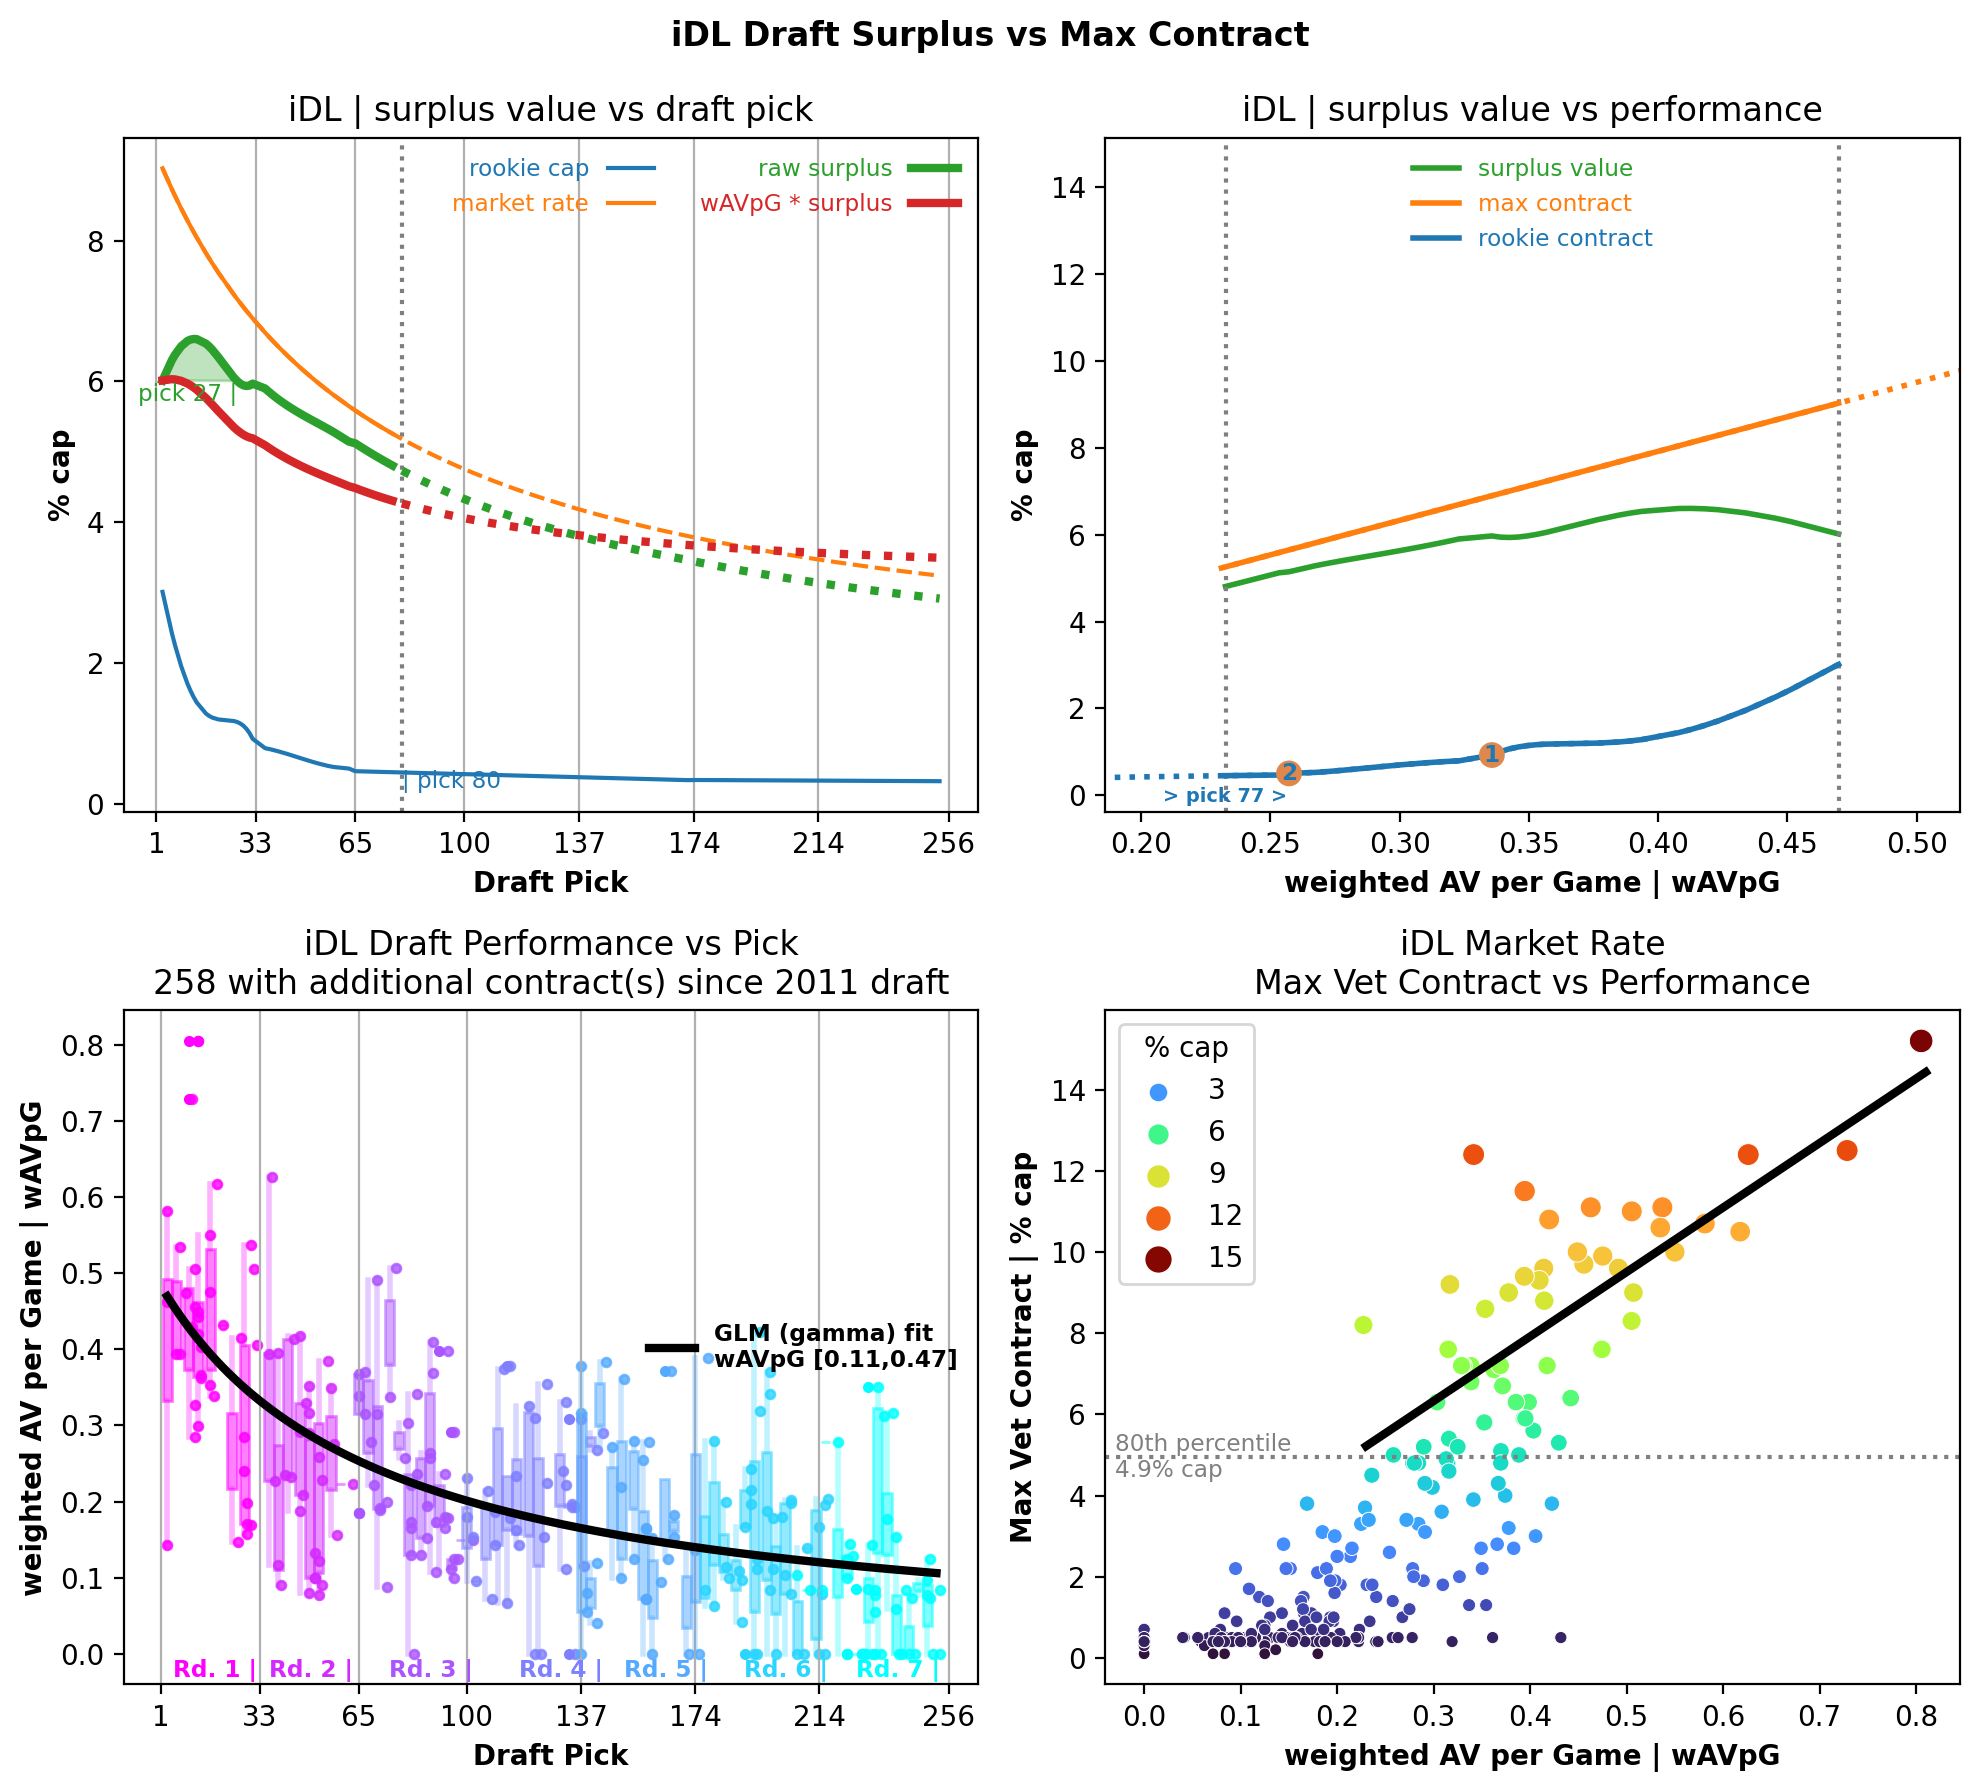

In [20]:
labels=True
cap_type = 'next'

for cap_type in ['next','max']:
    for labels in [True,False]:
        for pos in ['WR', 'CB', 'iDL',]:
            # ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']
            fig, axs = plt.subplots(
                nrows=2,ncols=2, sharey=False, layout='tight',
                figsize=(10,9), dpi=200,
                                    )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                axs[0][0], _, _, _,  _ = draft_surplus_pick(axs[0][0], data, pos, market, cap_type, labels=labels)
                axs[0][1], _, _, _,  _  = draft_surplus_performance(axs[0][1], data, pos, market, cap_type, labels=labels)
                axs[1][0] = draft_fit(axs[1][0], data, pos, labels=labels)
                axs[1][1] = market_fit(axs[1][1], data, pos, market, cap_type, labels=labels)
            plt.suptitle(f'{pos} Draft Surplus vs {"Second" if cap_type=="next" else "Max"} Contract', 
                         y=0.99, fontweight='bold')
            # if labels:
            #     plt.savefig(Path('market_graphs', 'FINAL SURPLUS', 'position grids',
            #                 f'{pos}_surplus_{cap_type}-market.png'), 
            #                 dpi=200, bbox_inches='tight')
            # else:
            #     plt.savefig(Path('market_graphs', 'FINAL SURPLUS', 'position grids', 'no labels',
            #                 f'{pos}_surplus_{cap_type}-market_no-labels.png'), 
            #                 dpi=200, bbox_inches='tight')                
            # plt.close()
            plt.show()

### Final Surplus Overlays
 - gather all curve traces, plot overlay

In [23]:
# FOR NOTEBOOK USAGE | SURPLUS vs PICK

surplus_curves = {}
for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    for cap_type in ['next','max']:
        fig, ax = plt.subplots()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax, picks, raw_surplus, p_surplus, overlap_pts = draft_surplus_pick(ax, data, pos, market, cap_type, labels=False)
        surplus_curves[f'{pos}_{cap_type}'] = {
            'picks': picks.values,
            'raw_surplus': raw_surplus,
            'p_surplus': p_surplus,
            'overlap': overlap_pts,
        }
        plt.close()

In [21]:
# FOR NOTEBOOK USAGE | SURPLUS vs wAVpG
surplus_curves = {} 

for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    for cap_type in ['next','max']:
        fig, ax = plt.subplots()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax, overlap_x, draft_surplus, draft_x, draft_fx = draft_surplus_performance(ax, data, pos, market, cap_type, labels=False)           
        
        surplus_curves[f'{pos}_{cap_type}'] = {
            'wAVpG': overlap_x,
            'surplus': draft_surplus.values,
            'draft_x': draft_x,
            'draft_fx': draft_fx,
        }
        plt.close()

**Compare Groupings**

*for surplus vs wAVpG, label peak of curves and equivalent draft rd/pick*

*label sides of graph (draft performance upper bound, market fit lower bound)*
 - ['T','iDL','EDGE']
 - ['LB','G','S']
 - ['C','RB','TE']
 - ['WR','CB']
 - ['QB','T','EDGE']

---
*vs wAVpG*

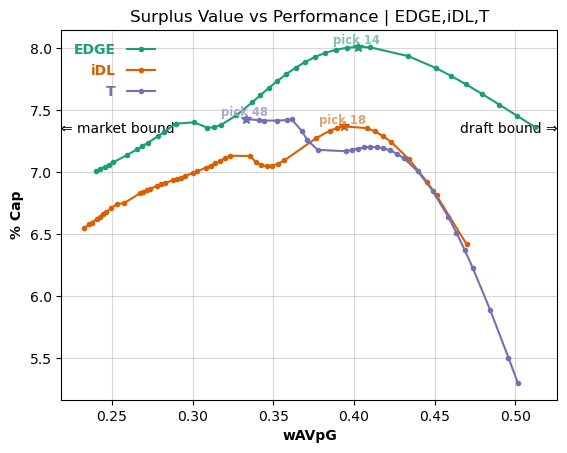

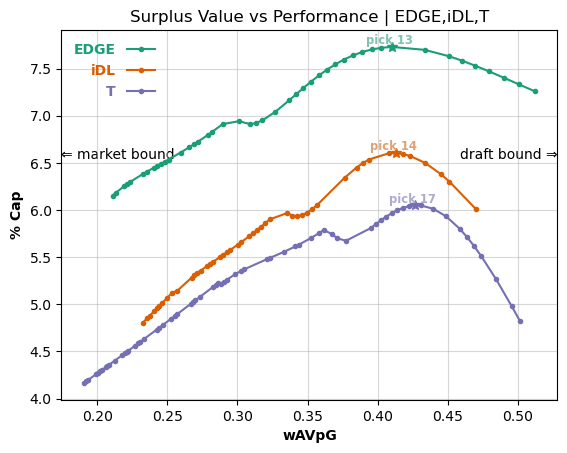

In [22]:
# cap_type = 'next', 'max'

colors = colormaps['Dark2'].colors

for cap_type in ['next', 'max']:
    for grouping in [
        ['EDGE','iDL','T',], #['LB','G','S'],['C','RB','TE'], ['WR','CB'], ['QB','EDGE','T'],
    ]:
        for i,pos in enumerate(grouping):
            c = colors[i]
            
            # surplus curve
            d = surplus_curves[f'{pos}_{cap_type}']
            trace = plt.plot(d['wAVpG'], d['surplus'],
                             '.-', label=pos, color=c)
            # label peak of curve and equivalent pick
            peak = np.argmax(d['surplus'])
            peak_pt = (d['wAVpG'][peak], d['surplus'][peak])
            # c = matplotlib.colors.to_rgb(trace[0].get_color())
            adj_c = [(val+0.9)/2 for val in c]
            if peak == 0:
                peak_match = 0
            else:
                peak_match = d['draft_x'].shape[0]-np.searchsorted(d['draft_x'][::-1], peak_pt[0])
            plt.plot(peak_pt[0],peak_pt[1], '*', c=c, markersize=7)
            plt.text(peak_pt[0],peak_pt[1], f'pick {d["draft_fx"].index[peak_match]} ', 
                     ha='center', c=adj_c, fontsize='small', fontweight='bold', va='bottom') 
        # label sides of graph
        xb = plt.xlim()
        yb = plt.ylim()
        plt.text(xb[0], 1.1*np.mean(yb), '⇐ market bound', zorder=0)
        plt.text(xb[1], 1.1*np.mean(yb), 'draft bound ⇒', zorder=0, ha='right')

        plt.legend(labelcolor='linecolor', prop={'weight':'bold'}, frameon=False, 
                   markerfirst=False,)
        plt.grid(alpha=0.5)
        plt.xlabel('wAVpG', fontweight='bold')
        plt.ylabel('% Cap', fontweight='bold')
        plt.title(f'Surplus Value vs Performance | {",".join(grouping)}')
    
        # plt.savefig(Path('market_graphs','FINAL SURPLUS', 'position comparisons',
        #                  f'surplus-{cap_type}-market_vs_wAVpG_{"-".join(grouping)}.png'),
        #             dpi=200, bbox_inches='tight')
        # plt.close()
        plt.show()

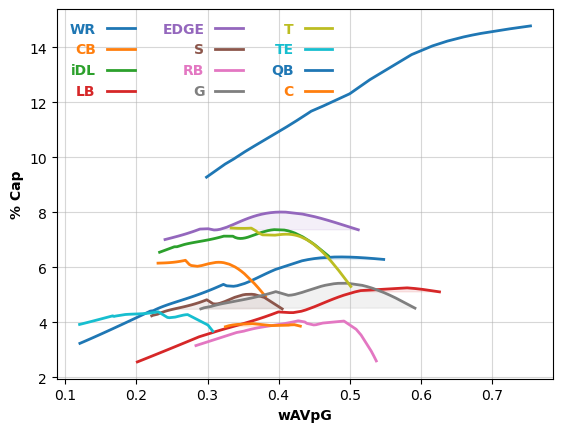

In [177]:
for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    d = surplus_curves[f'{pos}_next']
    trace = plt.plot(d['wAVpG'], d['surplus'],
                     '-', label=pos, linewidth=2)
    # fill region
    intersect = pd.Series(d['surplus'])
    if intersect[0] != intersect.min():
        intersect = intersect.loc[2:][intersect.loc[2:]<=intersect.loc[0]].index[0]
        plt.fill(d['wAVpG'][:intersect+1], d['surplus'][:intersect+1],
                color=trace[0].get_color(), alpha=0.1) 

plt.legend(labelcolor='linecolor', prop={'weight':'bold'}, frameon=False, 
           markerfirst=False, ncols=3)
#plt.xticks(rd_ticks)
plt.grid(alpha=0.5)
plt.xlabel('wAVpG', fontweight='bold')
plt.ylabel('% Cap', fontweight='bold')
# plt.savefig(Path('market_graphs','FINAL SURPLUS', f'surplus_compare_{"-".join(grouping)}.png'),
#             dpi=200, bbox_inches='tight')
plt.show()

---
*vs Pick*

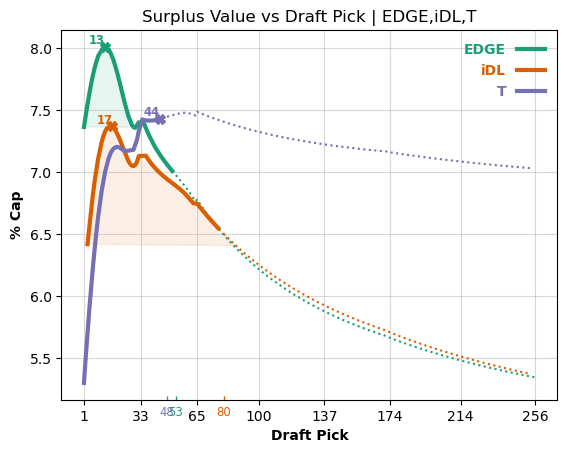

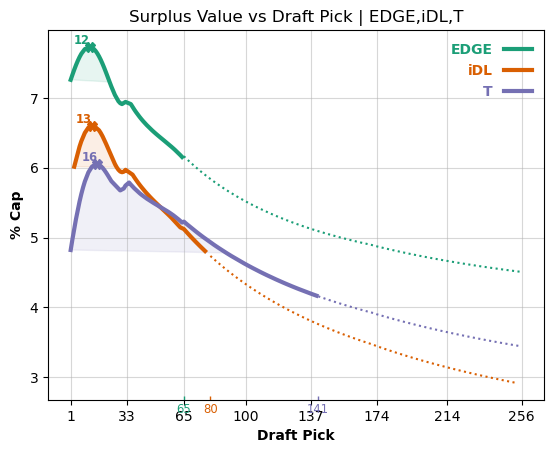

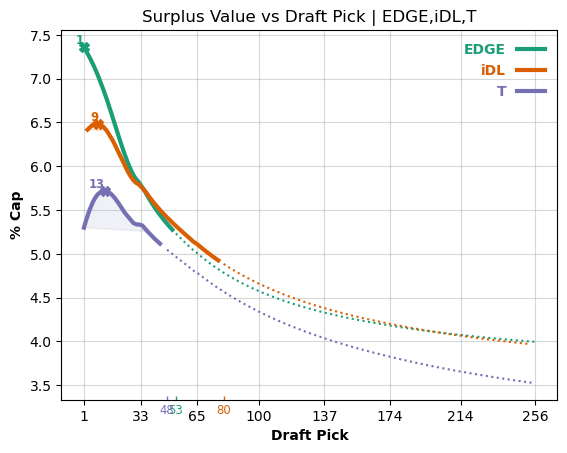

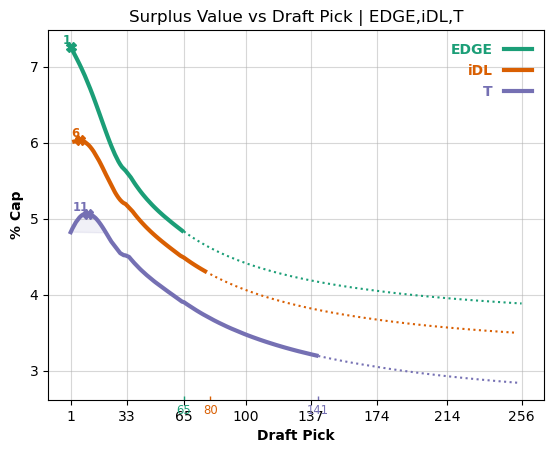

In [24]:
# 'raw_surplus', 'p_surplus'
# 'next', 'max'

colors = colormaps['Dark2'].colors

for py in [ 'raw_surplus', 'p_surplus']:
    for cap_type in ['next', 'max']:
        for grouping in [
            ['EDGE','iDL','T',], #['LB','G','S'],['C','RB','TE'], ['WR','CB'], ['QB','EDGE','T'],
                        ]:
            extrap_labels = {}
            for i,pos in enumerate(grouping):
                c = colors[i]
                d = surplus_curves[f'{pos}_{cap_type}']
                trace = plt.plot(d['picks'][:d['overlap']], d[py][:d['overlap']],
                                 '-', label=pos, linewidth=3, color=c)
                plt.plot(d['picks'][d['overlap']:], d[py][d['overlap']:],
                         ':', color=c)
                # fill region
                intersect = pd.Series(d[py])
                if intersect[0] != intersect.min():
                    intersect = intersect.loc[2:][intersect.loc[2:]<=intersect.loc[0]].index[0]
                    plt.fill(d['picks'][:intersect+1], d[py][:intersect+1],
                            color=c, alpha=0.1) 
                # label peak on curve
                peak = np.argmax(d[py][:d['overlap']])
                plt.plot(d['picks'][peak], d[py][peak], 'X', color=c, markersize=7)
                plt.text(d['picks'][peak], d[py][peak], d['picks'][peak], fontsize='small',
                         fontweight='bold', color=c, ha='right', va='bottom')

                # label extrapolation on X-Axis
                extrap_labels[pos] = {'pick':d['picks'][d['overlap']], 
                                      'color':c}
            
            # label extrapolation on X-Axis
            yb = plt.ylim()
            for pos in extrap_labels.keys():
                plt.plot(extrap_labels[pos]['pick'], yb[0], '|',
                         color=extrap_labels[pos]['color'])
                plt.text(extrap_labels[pos]['pick'], yb[0]-0.05, 
                         extrap_labels[pos]['pick'], color=extrap_labels[pos]['color'],
                         ha='center', fontsize='small', va='top')
            plt.ylim(yb)
            
            plt.legend(labelcolor='linecolor', prop={'weight':'bold'}, frameon=False, 
                       markerfirst=False)
            plt.xticks(rd_ticks)
            plt.grid(alpha=0.5)
            plt.xlabel('Draft Pick', fontweight='bold')
            plt.ylabel('% Cap', fontweight='bold')
            plt.title(f'Surplus Value vs Draft Pick | {",".join(grouping)}')
        
#             if py == 'p_surplus':
#                 plt.savefig(Path('market_graphs','FINAL SURPLUS', 'position comparisons', 'performance weighted surplus',
#                                  f'surplus-{cap_type}-market_vs_pick_{"-".join(grouping)}.png'),
#                             dpi=200, bbox_inches='tight')
#             else:
#                 plt.savefig(Path('market_graphs','FINAL SURPLUS', 'position comparisons',
#                                  f'surplus-{cap_type}-market_vs_pick_{"-".join(grouping)}.png'),
#                             dpi=200, bbox_inches='tight')                
#             plt.close()
            plt.show()

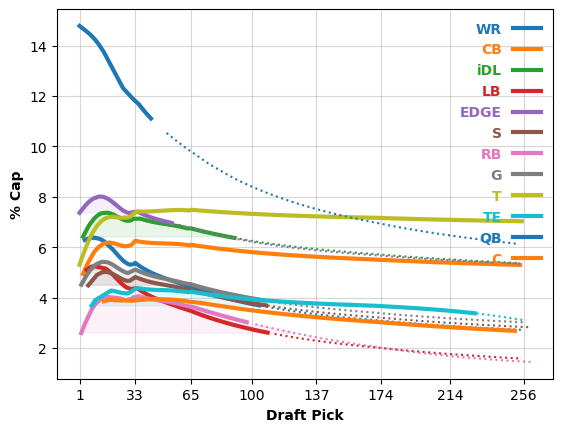

In [182]:
for pos in ['WR', 'CB', 'iDL', 'LB', 'EDGE', 'S', 'RB', 'G', 'T', 'TE', 'QB', 'C']:
    d = surplus_curves[f'{pos}_next']
    trace = plt.plot(d['picks'][:d['overlap']], d['raw_surplus'][:d['overlap']],
                     '-', label=pos, linewidth=3)
    plt.plot(d['picks'][d['overlap']:], d['raw_surplus'][d['overlap']:],
             ':', color=trace[0].get_color())
    # fill region
    intersect = pd.Series(d['raw_surplus'])
    if intersect[0] != intersect.min():
        intersect = intersect.loc[2:][intersect.loc[2:]<=intersect.loc[0]].index[0]
        plt.fill(d['picks'][:intersect+1], d['raw_surplus'][:intersect+1],
                color=trace[0].get_color(), alpha=0.1) 

plt.legend(labelcolor='linecolor', prop={'weight':'bold'}, frameon=False, 
           markerfirst=False)
plt.xticks(rd_ticks)
plt.grid(alpha=0.5)
plt.xlabel('Draft Pick', fontweight='bold')
plt.ylabel('% Cap', fontweight='bold')
# plt.savefig(Path('market_graphs','FINAL SURPLUS', f'surplus_compare_{"-".join(grouping)}.png'),
#             dpi=200, bbox_inches='tight')
plt.show()